In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup as bs
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from pymystem3 import Mystem
from string import punctuation
from nltk.stem.snowball import SnowballStemmer
import spacy
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# https://www.geeksforgeeks.org/scraping-reddit-using-python/
# triplet loss
# https://github.com/sjhddh/reddit_time_machine/blob/master/apis/redditAPI.py

## PREPROCESSING FUNCTIONED

In [ ]:
def preprocessing_data(N_ARTICLES=25, PREPROC=None, STOPWORDS=False, TARGET_DAY='same', NGRAM=(1,1), TFIDF_MAXFEAT=None):
  # news texts 
  news = pd.read_csv('/content/drive/My Drive/thesis/Combined_News_DJIA.csv').fillna('')
  
  # dates in news
  month_mapper = {1:'01. Jan', 2:'02. Feb', 3:'03. Mar', 4:'04. Apr', 5:'05. May', 6:'06. Jun', 
                7:'07. Jul', 8:'08. Aug', 9:'09. Sep', 10:'10. Oct', 11:'11. Nov', 12:'12. Dec'}
  news['Datedate'] = pd.to_datetime(news.Date)
  news['weekday'] = news.Datedate.apply(lambda x: x.weekday())
  news['year'] = news.Date.apply(lambda x: str(x)[:4])
  news['year_month'] = news.Date.apply(lambda x: str(x)[:7])
  news['month'] = news.Date.apply(lambda x: str(x)[5:7])
  news['quarter'] = news.Date.apply(lambda x: 'Q' + str((int(str(x)[5:7])-1) // 3 + 1))
  news['year_quarter'] = news.Date.apply(lambda x: str(x)[:4] + '-Q' + str((int(str(x)[5:7])-1) // 3 + 1))
  news['month_text'] = news.Date.apply(lambda x: month_mapper[int(str(x)[5:7])])

  # headline concatenation
  for i in range(1, N_ARTICLES+1):
    if i == 1:
        news['headlines_concat'] = news['Top1'].apply(CountVectorizer().build_tokenizer())
    else:
        news['headlines_concat'] += news['Top'+str(i)].apply(CountVectorizer().build_tokenizer())
  
  # text preprocessing
  stemmer = SnowballStemmer('english')
  lemmatizer = WordNetLemmatizer()
  nltk_stopwords_set = list(set(stopwords.words('english')))

  if PREPROC==None:
    # news['headlines_stem'] = news['headlines_concat'].apply(lambda x: ' '.join(x))
    news['headlines_stem'] = news['headlines_concat'].apply(lambda sent: ' '.join([
      w.lower() for w in sent 
      if w.lower() not in STOPWORDS*nltk_stopwords_set 
      and w not in punctuation]))
  elif PREPROC=='STEM':
    news['headlines_stem'] = news['headlines_concat'].apply(lambda sent: ' '.join([
      stemmer.stem(w.lower()) for w in sent 
      if w.lower() not in STOPWORDS*nltk_stopwords_set 
      and w not in punctuation]))
  elif PREPROC=='LEMM':
    news['headlines_stem'] = news['headlines_concat'].apply(lambda sent: ' '.join([
      lemmatizer.lemmatize(w.lower()) for w in sent 
      if w.lower() not in STOPWORDS*nltk_stopwords_set 
      and w not in punctuation]))
  
  # DJIA 
  dji = pd.read_csv('/content/drive/My Drive/thesis/^dji_d.csv')
  dji['Datedate'] = pd.to_datetime(dji.Date)
  dji['Close_trailing5'] = dji['Close'].rolling(min_periods=1, window=5).mean()
  dji['Close_trailing30'] = dji['Close'].rolling(min_periods=1, window=30).mean()
  dji['Volume_trailing5'] = dji['Volume'].rolling(min_periods=1, window=5).mean()
  dji['Volume_trailing30'] = dji['Volume'].rolling(min_periods=1, window=30).mean()
  dji['Close_maxmin5'] = dji['Close'].rolling(min_periods=1, window=5).max() / dji['Close'].rolling(min_periods=1, window=5).min()
  dji['Close_maxmin30'] = dji['Close'].rolling(min_periods=1, window=5).max() / dji['Close'].rolling(min_periods=1, window=5).min()
  dji['Close_rate2'] = dji['Close'] / dji['Close'].rolling(min_periods=1, window=2).agg(lambda rows: np.array(rows)[0])
  dji['Close_rate5'] = dji['Close'] / dji['Close'].rolling(min_periods=1, window=5).agg(lambda rows: np.array(rows)[0])
  dji['Close_rate30'] = dji['Close'] / dji['Close'].rolling(min_periods=1, window=30).agg(lambda rows: np.array(rows)[0])
  dji['Close_maxmin5_perc'] = (dji['Close_maxmin5'] - 1)*100
  dji['Close_maxmin30_perc'] = (dji['Close_maxmin30'] - 1)*100
  dji['Close_rate2_perc'] = (dji['Close_rate2'] - 1)*100
  dji['Close_rate5_perc'] = (dji['Close_rate5'] - 1)*100
  dji['Close_rate30_perc'] = (dji['Close_rate30'] - 1)*100

  # connect news w previous day market info
  dji['Datedate_next'] = list(dji.Datedate)[1:] + [list(dji.Datedate)[-1]+pd.DateOffset(1)]
  comb_df = news.merge(dji, left_on='Datedate', right_on='Datedate_next', how='left', suffixes=('', '_dji'))
  # print(news.shape, comb_df.shape)

  # define DJIA target
  df = comb_df.sort_values('Date')[['headlines_stem', 'Label']].copy()
  if TARGET_DAY=='same':
    df['target'] = df['Label']
  elif TARGET_DAY=='next':
    df['target'] = list(df['Label'])[1:] + [0]
  
  # split data
  val_thr = len(df) - (len(df) // 4)
  X_train, X_val, y_train, y_val = df.headlines_stem[:val_thr], df.headlines_stem[val_thr:], df.target[:val_thr], df.target[val_thr:]
  # vectorize texts
  vectorizer = TfidfVectorizer(ngram_range=NGRAM, max_features=TFIDF_MAXFEAT)
  train_transf = vectorizer.fit_transform(X_train)
  val_transf = vectorizer.transform(X_val)

  return train_transf, val_transf, y_train, y_val, vectorizer, comb_df

## MODEL + EVALUATION

### texts

In [ ]:
train_transf, val_transf, y_train, y_val, vectorizer, comb_df = preprocessing_data(N_ARTICLES=25, 
                                                                                   PREPROC='STEM', # None 
                                                                                   STOPWORDS=True, 
                                                                                   TARGET_DAY='same', 
                                                                                   NGRAM=(2,2), 
                                                                                   TFIDF_MAXFEAT=None)

In [ ]:
train_transf.shape

(1492, 317735)

In [ ]:
# model
cbr = LogisticRegression(C=10, max_iter=100) # C=10
# cbr = CatBoostClassifier(iterations=100,max_depth=4) # ,learning_rate=1
cbr.fit(train_transf, y_train)

cbr_pred = cbr.predict(val_transf)
cbr_pred_proba = cbr.predict_proba(val_transf)
print('Validation accuracy: {}'.format(accuracy_score(y_val, cbr_pred)))
print('Validation precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_val, cbr_pred, average='binary')))
print('Validation roc_auc_score: {}'.format(roc_auc_score(y_val, cbr_pred_proba[:, 1])))
print(cbr_pred.sum() / val_transf.shape[0])

cbr_pred = cbr.predict(train_transf)
cbr_pred_proba = cbr.predict_proba(train_transf)
print('\nTrain accuracy: {}'.format(accuracy_score(y_train, cbr_pred)))
print('Train precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_train, cbr_pred, average='binary')))
print('Train roc_auc_score: {}'.format(roc_auc_score(y_train, cbr_pred_proba[:, 1])))

Validation accuracy: 0.5110663983903421
Validation precision_recall_fscore_support: (0.5152838427947598, 0.9182879377431906, 0.6601398601398601, None)
Validation roc_auc_score: 0.5291990920881972
0.9215291750503019

Train accuracy: 1.0
Train precision_recall_fscore_support: (1.0, 1.0, 1.0, None)
Train roc_auc_score: 1.0


### grid search hyperparams

In [ ]:
### grid search
for N_ARTICLES in [5, 15, 25]:
  for PREPROC in [None, 'STEM']:
    for STOPWORDS in [False, True]:
      for NGRAM in [(1,1), (2,2)]:
        for TFIDF_MAXFEAT in [None, 5000, 10000]:


          train_transf, val_transf, y_train, y_val, vectorizer, comb_df = preprocessing_data(N_ARTICLES=N_ARTICLES, 
                                                                                            PREPROC=PREPROC,
                                                                                            STOPWORDS=STOPWORDS, 
                                                                                            TARGET_DAY='same', 
                                                                                            NGRAM=NGRAM, 
                                                                                            TFIDF_MAXFEAT=TFIDF_MAXFEAT)
          cbr = LogisticRegression(C=10, max_iter=100)
          cbr.fit(train_transf, y_train)
          cbr_pred = cbr.predict(val_transf)
          cbr_pred_proba = cbr.predict_proba(val_transf)[:, 1]
          mean_thr = cbr_pred_proba.mean()

          if abs(accuracy_score(y_val, cbr_pred)-0.5)>0.01 or abs(accuracy_score(y_val, np.where(cbr_pred_proba>mean_thr, 1, 0))-0.5)>0.01:
            print(N_ARTICLES, PREPROC, STOPWORDS, NGRAM, TFIDF_MAXFEAT)
            print('Validation accuracy: {}'.format(accuracy_score(y_val, cbr_pred)))
            print('Validation accuracy w threshold: {}'.format(accuracy_score(y_val, np.where(cbr_pred_proba>mean_thr, 1, 0))))
            print('Validation precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_val, cbr_pred, average='binary')))
            print('Validation roc_auc_score: {}'.format(roc_auc_score(y_val, cbr_pred_proba)))
            print(cbr_pred.sum() / val_transf.shape[0], '\n')
          else: 
            print(N_ARTICLES, PREPROC, STOPWORDS, NGRAM, TFIDF_MAXFEAT, '\n')

5 None False (1, 1) None
Validation accuracy: 0.5211267605633803
Validation accuracy w threshold: 0.48893360160965793
Validation precision_recall_fscore_support: (0.5313531353135313, 0.6264591439688716, 0.5750000000000001, None)
Validation roc_auc_score: 0.49933527885862516
0.6096579476861167 

5 None False (1, 1) 5000 

5 None False (1, 1) 10000 

5 None False (2, 2) None
Validation accuracy: 0.48088531187122735
Validation accuracy w threshold: 0.47283702213279677
Validation precision_recall_fscore_support: (0.4985754985754986, 0.6809338521400778, 0.5756578947368421, None)
Validation roc_auc_score: 0.4696822308690013
0.7062374245472837 

5 None False (2, 2) 5000
Validation accuracy: 0.482897384305835
Validation accuracy w threshold: 0.4869215291750503
Validation precision_recall_fscore_support: (0.5, 0.5252918287937743, 0.5123339658444024, None)
Validation roc_auc_score: 0.48915369649805446
0.5432595573440644 

5 None False (2, 2) 10000 

5 None True (1, 1) None
Validation accuracy: 0

In [ ]:
# 25 STEM False (2, 2) 10000
# 25 None True (2, 2) 10000
# 25 None True (2, 2) None
# 15 None False (2, 2) 5000

# 25 STEM False (2, 2) 5000
# 25 STEM False (2, 2) None
# 25 None False (2, 2) 10000 aaa
# 25 None False (2, 2) None

Validation accuracy: 0.5513078470824949
Validation accuracy w threshold: 0.5714285714285714
Validation precision_recall_fscore_support: (0.5521472392638037, 0.7003891050583657, 0.6174957118353345, None)
Validation roc_auc_score: 0.5815175097276265
0.6559356136820925


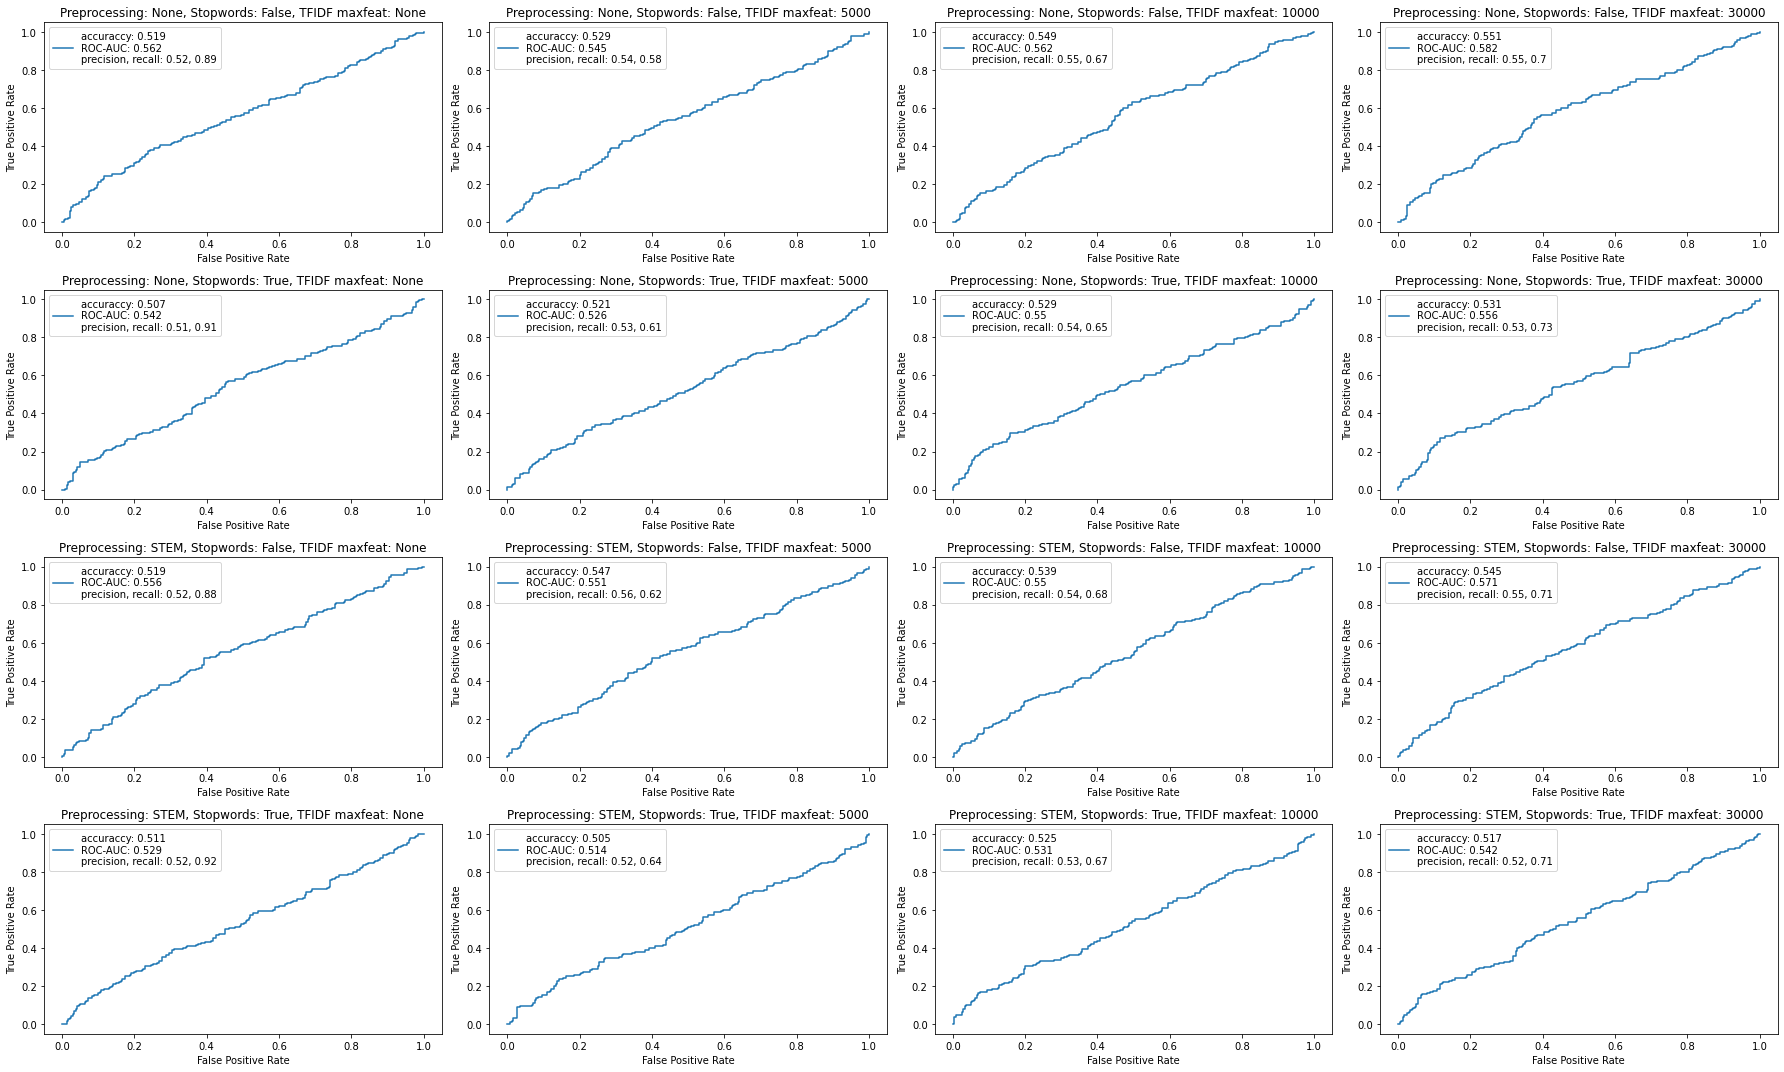

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

rows, cols = 4, 4
fig, ax = plt.subplots(rows, cols, figsize=(25,15))
cnt = 0

### grid search
for PREPROC in [None, 'STEM']:
  for STOPWORDS in [False, True]:
      for TFIDF_MAXFEAT in [None, 5000, 10000, 30000]:
# N_ARTICLES, PREPROC, STOPWORDS, NGRAM, TFIDF_MAXFEAT = 25, None, False, (2, 2), 10000
        train_transf, val_transf, y_train, y_val, vectorizer, comb_df = preprocessing_data(N_ARTICLES=25, 
                                                                                                    PREPROC=PREPROC,
                                                                                                    STOPWORDS=STOPWORDS, 
                                                                                                    TARGET_DAY='same', 
                                                                                                    NGRAM=(2,2), 
                                                                                                    TFIDF_MAXFEAT=TFIDF_MAXFEAT)
        cbr = LogisticRegression(C=10, max_iter=100)
        cbr.fit(train_transf, y_train)
        cbr_pred = cbr.predict(val_transf)
        cbr_pred_proba = cbr.predict_proba(val_transf)[:, 1]
        mean_thr = cbr_pred_proba.mean()
        
        # metrics
        lr_auc = round(roc_auc_score(y_val, cbr_pred_proba), 3)
        fpr, tpr, _ = roc_curve(y_val, cbr_pred_proba)
        acc = round(accuracy_score(y_val, cbr_pred), 3)
        pr, rec, f1, sup = precision_recall_fscore_support(y_val, cbr_pred, average='binary')

        # plot the roc curve for the model
        fig.tight_layout()
        ax[cnt//cols, cnt%cols].plot(fpr, tpr, label='accuraccy: {}\nROC-AUC: {}\nprecision, recall: {}, {}'.format(acc, lr_auc, round(pr,2), round(rec,2)))
        ax[cnt//cols, cnt%cols].set_title('Preprocessing: {}, Stopwords: {}, TFIDF maxfeat: {}'.format(PREPROC, STOPWORDS, TFIDF_MAXFEAT))
        ax[cnt//cols, cnt%cols].set_xlabel('False Positive Rate')
        ax[cnt//cols, cnt%cols].set_ylabel('True Positive Rate')
        ax[cnt//cols, cnt%cols].legend()
        cnt += 1

plt.show()

### model insights

In [ ]:
# # best baseline on gridsearch
# train_transf, val_transf, y_train, y_val, vectorizer, comb_df = preprocessing_data(N_ARTICLES=25,
#                                                                                    PREPROC=None,
#                                                                                    STOPWORDS=False,
#                                                                                    TARGET_DAY='same',
#                                                                                    NGRAM=(2,2), 
#                                                                                    TFIDF_MAXFEAT=30000)
# cbr = LogisticRegression(C=10, max_iter=100)
# cbr.fit(train_transf, y_train)
# cbr_pred = cbr.predict(val_transf)
# cbr_pred_proba = cbr.predict_proba(val_transf)[:, 1]
# mean_thr = cbr_pred_proba.mean()
# print('Validation accuracy: {}'.format(accuracy_score(y_val, cbr_pred)))
# print('Validation accuracy w threshold: {}'.format(accuracy_score(y_val, np.where(cbr_pred_proba>mean_thr, 1, 0))))
# print('Validation precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_val, cbr_pred, average='binary')))
# print('Validation roc_auc_score: {}'.format(roc_auc_score(y_val, cbr_pred_proba)))
# print(cbr_pred.sum() / val_transf.shape[0])

Validation accuracy: 0.5513078470824949
Validation accuracy w threshold: 0.5714285714285714
Validation precision_recall_fscore_support: (0.5521472392638037, 0.7003891050583657, 0.6174957118353345, None)
Validation roc_auc_score: 0.5815175097276265
0.6559356136820925


In [ ]:
# try to tIMES 5 the dataset

# best baseline on gridsearch
train_transf, val_transf, y_train, y_val, vectorizer, comb_df = preprocessing_data(N_ARTICLES=25,
                                                                                   PREPROC='LEMM',
                                                                                   STOPWORDS=True,
                                                                                   TARGET_DAY='same',
                                                                                   NGRAM=(2,2), 
                                                                                   TFIDF_MAXFEAT=None)

# ## NEXT DAY TARGET
# comb_df = comb_df.sort_values('Date')
# comb_df['Label'] = list(comb_df['Label'])[1:] + [0]
# ## ###

# # headline concatenation
# for j in range(5):
#   for i in range(j*5+1, j*5+5+1):
#     if i%5 == 1:
#         comb_df['headlines'+str(j)+'_concat'] = comb_df['Top'+str(i)].apply(CountVectorizer().build_tokenizer())
#     else:
#         comb_df['headlines'+str(j)+'_concat'] += comb_df['Top'+str(i)].apply(CountVectorizer().build_tokenizer())

# # text preprocessing
# stemmer = SnowballStemmer('english')
# lemmatizer = WordNetLemmatizer()
# nltk_stopwords_set = list(set(stopwords.words('english')))

# for j in range(5):
#   comb_df['headlines'+str(j)+'_stem'] = comb_df['headlines'+str(j)+'_concat'].apply(lambda sent: ' '.join([
#     # lemmatizer.lemmatize(w.lower()) for w in sent
#     w.lower() for w in sent
#     # if w.lower() not in nltk_stopwords_set 
#     if w not in punctuation]))

###
for i in range(1, 25+1):
    if i == 1:
        comb_df['headlines_concat'] = comb_df['Top1'].apply(CountVectorizer().build_tokenizer())
    else:
        comb_df['headlines_concat'] += comb_df['Top'+str(i)].apply(CountVectorizer().build_tokenizer())

comb_df['headlines_stem'] = comb_df['headlines_concat'].apply(lambda sent: ' '.join([
      w.lower() for w in sent
      # if w.lower() not in nltk_stopwords_set ########### 
      if w not in punctuation]))
###

# comb_df = pd.concat([comb_df[['headlines0_stem', 'Label', 'Date']].rename(columns={"headlines0_stem": "headlines_stem"}),
#                      comb_df[['headlines1_stem', 'Label', 'Date']].rename(columns={"headlines1_stem": "headlines_stem"}),
#                      comb_df[['headlines2_stem', 'Label', 'Date']].rename(columns={"headlines2_stem": "headlines_stem"}),
#                      comb_df[['headlines3_stem', 'Label', 'Date']].rename(columns={"headlines3_stem": "headlines_stem"}),
#                      comb_df[['headlines4_stem', 'Label', 'Date']].rename(columns={"headlines4_stem": "headlines_stem"})]).reset_index(drop=True)

# comb_df = comb_df.sort_values(by='Date', ascending=True).drop(columns=['Date']).reset_index(drop=True)

# split data
val_thr = len(comb_df) - (len(comb_df) // 5)
X_train, X_val, y_train, y_val = comb_df.headlines_stem[:val_thr], comb_df.headlines_stem[val_thr:], comb_df.Label[:val_thr], comb_df.Label[val_thr:]
# vectorize texts
vectorizer = TfidfVectorizer(ngram_range=(2,2), max_features=30000) 
train_transf = vectorizer.fit_transform(X_train)
val_transf = vectorizer.transform(X_val)

In [ ]:
from catboost import CatBoostClassifier

# cbr = LogisticRegression(C=10, max_iter=100) # C=10
# cbr.fit(train_transf, y_train)
cbr = CatBoostClassifier(iterations=500, max_depth=4, learning_rate=1)
cbr.fit(train_transf, y_train, silent=True)

cbr_pred = cbr.predict(train_transf)
cbr_pred_proba = cbr.predict_proba(train_transf)[:, 1]
mean_thr = cbr_pred_proba.mean()
print('Train accuracy: {}'.format(accuracy_score(y_train, cbr_pred)))
print('Train accuracy w threshold: {}'.format(accuracy_score(y_train, np.where(cbr_pred_proba>mean_thr, 1, 0))))
print('Train precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_train, cbr_pred, average='binary')))
print('Train roc_auc_score: {}'.format(roc_auc_score(y_train, cbr_pred_proba)))
print(cbr_pred.sum() / train_transf.shape[0])

cbr_pred = cbr.predict(val_transf)
cbr_pred_proba = cbr.predict_proba(val_transf)[:, 1]
print('\nValidation accuracy: {}'.format(accuracy_score(y_val, cbr_pred)))
print('Validation accuracy w threshold: {}'.format(accuracy_score(y_val, np.where(cbr_pred_proba>mean_thr, 1, 0))))
print('Validation precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_val, cbr_pred, average='binary')))
print('Validation roc_auc_score: {}'.format(roc_auc_score(y_val, cbr_pred_proba)))
print(cbr_pred.sum() / val_transf.shape[0])

Train accuracy: 1.0
Train accuracy w threshold: 1.0
Train precision_recall_fscore_support: (1.0, 1.0, 1.0, None)
Train roc_auc_score: 1.0
0.542713567839196

Validation accuracy: 0.5440806045340051
Validation accuracy w threshold: 0.5667506297229219
Validation precision_recall_fscore_support: (0.5384615384615384, 0.6965174129353234, 0.6073752711496746, None)
Validation roc_auc_score: 0.59259823332318
0.654911838790932


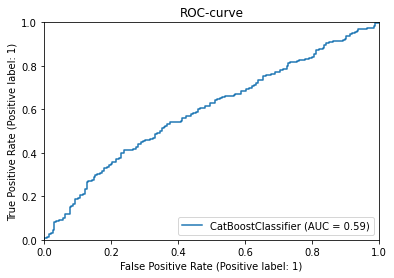

In [ ]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_val, cbr_pred_proba)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC-curve')
plt.plot(fpr, tpr, label = 'CatBoostClassifier (AUC = %0.2f)' % roc_auc) # , 'b'
plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Positive label: 1)')
plt.xlabel('False Positive Rate (Positive label: 1)')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


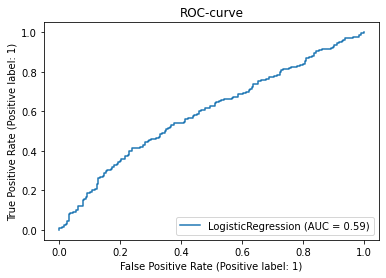

In [ ]:
from sklearn import metrics

metrics.plot_roc_curve(cbr, val_transf, y_val, ) 
plt.title('ROC-curve')
plt.show()

In [ ]:
import shap

# explainer = shap.Explainer(cbr)
# shap_values = explainer(train_transf, vectorizer)
explainer = shap.LinearExplainer(cbr,train_transf) #,feature_dependence="independent")
shap_values = explainer(train_transf)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


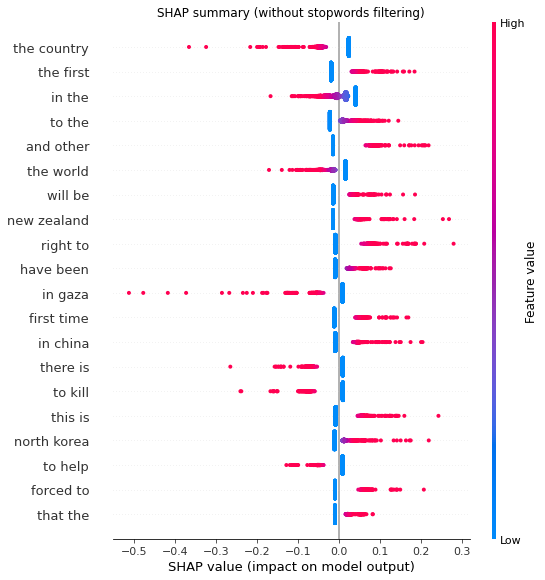

In [ ]:
plt.title('SHAP summary (without stopwords filtering)')
shap.summary_plot(shap_values,train_transf.toarray(),
                  feature_names=vectorizer.get_feature_names(), plot_type='dot')

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


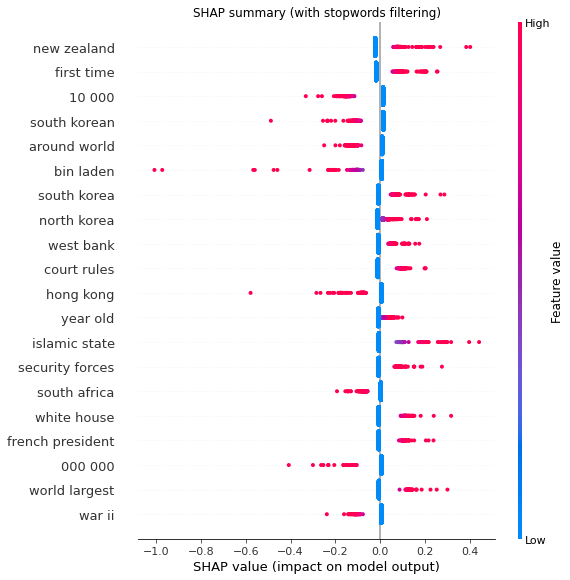

In [ ]:
plt.title('SHAP summary (with stopwords filtering)')
shap.summary_plot(shap_values,train_transf.toarray(),
                  feature_names=vectorizer.get_feature_names(), plot_type='dot')

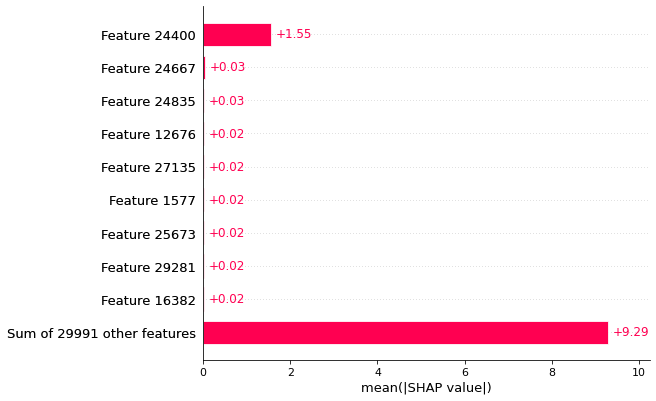

In [ ]:
shap.plots.bar(shap_values)

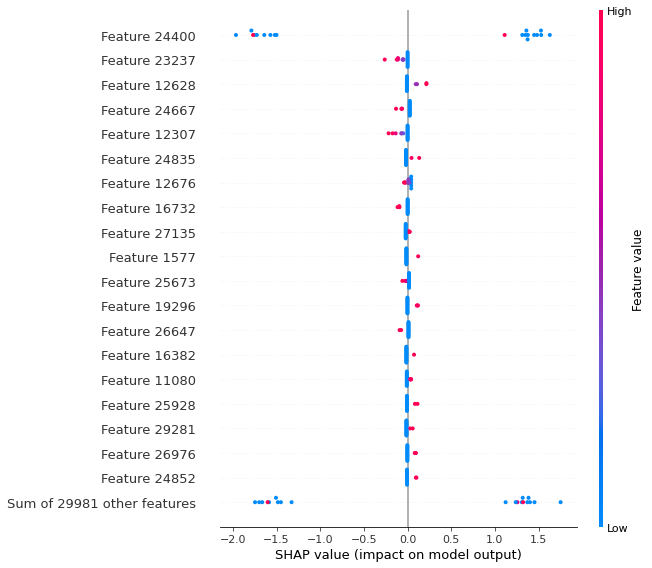

In [ ]:
shap.plots.beeswarm(shap_values[:20])

In [ ]:
shap.plots.waterfall(shap_values[0], feature_names=vectorizer.get_feature_names())

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


TypeError: ignored

In [ ]:
# hp choice
# for PREPROC in ['LEMM', 'STEMM', None]:
#   for STOPWORDS in [True, False]: 
# for NGRAM in [(1,1), (2,2)]:
for PREPROC in ['LEMM', None]: # , 'STEMM'
  for TFIDF_MAXFEAT in [10000, 30000]:
    for iterations in [300, 1000]:
      for maxdepth in [4, 6, 8]:
        print(PREPROC, TFIDF_MAXFEAT, iterations, maxdepth)
        train_transf, val_transf, y_train, y_val, vectorizer, comb_df = preprocessing_data(N_ARTICLES=25,
                                                                                           PREPROC=PREPROC,
                                                                                           STOPWORDS=False,
                                                                                           TARGET_DAY='same',
                                                                                           NGRAM=(2,2), 
                                                                                           TFIDF_MAXFEAT=TFIDF_MAXFEAT)

        # cbr = LogisticRegression(C=10, max_iter=100)
        # cbr.fit(train_transf, y_train)
        cbr = CatBoostClassifier(iterations=iterations, max_depth=maxdepth) # ,learning_rate=1
        cbr.fit(train_transf, y_train, silent=True)

        cbr_pred = cbr.predict(val_transf)
        cbr_pred_proba = cbr.predict_proba(val_transf)[:, 1]
        mean_thr = cbr_pred_proba.mean()
        print('Validation accuracy: {}'.format(accuracy_score(y_val, cbr_pred)))
        print('Validation accuracy w threshold: {}'.format(accuracy_score(y_val, np.where(cbr_pred_proba>mean_thr, 1, 0))))
        print('Validation precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_val, cbr_pred, average='binary')))
        print('Validation roc_auc_score: {}'.format(roc_auc_score(y_val, cbr_pred_proba)))
        print(cbr_pred.sum() / val_transf.shape[0])
        print('\n')

LEMM 10000 300 4
Validation accuracy: 0.5050301810865191
Validation accuracy w threshold: 0.5291750503018109
Validation precision_recall_fscore_support: (0.515850144092219, 0.6964980544747081, 0.5927152317880794, None)
Validation roc_auc_score: 0.5200713359273671
0.6981891348088531


LEMM 10000 300 6
Validation accuracy: 0.5291750503018109
Validation accuracy w threshold: 0.5311871227364185
Validation precision_recall_fscore_support: (0.532394366197183, 0.7354085603112841, 0.6176470588235294, None)
Validation roc_auc_score: 0.5248865110246433
0.7142857142857143


LEMM 10000 300 8
Validation accuracy: 0.5251509054325956
Validation accuracy w threshold: 0.5171026156941649
Validation precision_recall_fscore_support: (0.5335463258785943, 0.6498054474708171, 0.5859649122807018, None)
Validation roc_auc_score: 0.5040856031128405
0.6297786720321932


LEMM 10000 1000 4
Validation accuracy: 0.5110663983903421
Validation accuracy w threshold: 0.5191146881287726
Validation precision_recall_fscore

In [ ]:
from IPython.display import Markdown, display
from sklearn.metrics import classification_report
from sklearn import metrics

cbr_pred = cbr.predict(val_transf)
cbr_pred_proba = cbr.predict_proba(val_transf)[:, 1]

def printmd(string):
    display(Markdown(string))

printmd('**Classification report with probability threshold at 0.5:**')
print(classification_report(y_val, cbr_pred))
printmd('\n**Classification report with probability threshold at distribution mean:**')
print(classification_report(y_val, np.where(cbr_pred_proba>mean_thr, 1, 0)))

**Classification report with probability threshold at 0.5:**

              precision    recall  f1-score   support

           0       0.55      0.39      0.46       196
           1       0.54      0.70      0.61       201

    accuracy                           0.54       397
   macro avg       0.55      0.54      0.53       397
weighted avg       0.55      0.54      0.53       397




**Classification report with probability threshold at distribution mean:**

              precision    recall  f1-score   support

           0       0.57      0.52      0.54       196
           1       0.57      0.61      0.59       201

    accuracy                           0.57       397
   macro avg       0.57      0.57      0.57       397
weighted avg       0.57      0.57      0.57       397



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


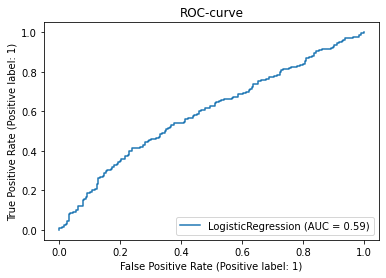

In [ ]:
metrics.plot_roc_curve(cbr, val_transf, y_val) 
plt.title('ROC-curve')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


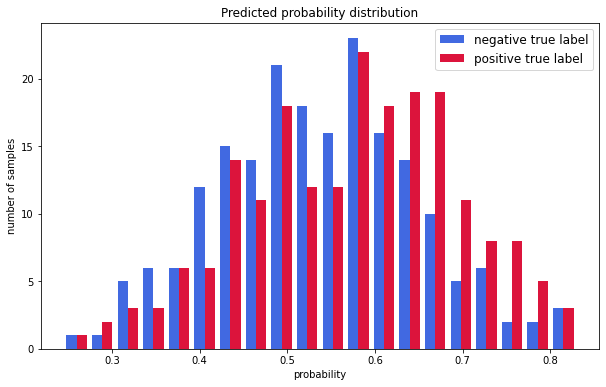

In [ ]:
plt.figure(figsize=(10, 6))
# plt.hist(cbr_pred_proba[:, 1], bins=30, color='royalblue', label='Word2Vec + catboost') 
plt.hist([cbr_pred_proba[y_val==0], cbr_pred_proba[y_val==1]], 
         color=['royalblue', 'crimson'], 
         label=['negative true label', 'positive true label'], bins=20)
plt.title('Predicted probability distribution')
plt.xlabel('probability')
plt.ylabel('number of samples')
plt.legend(prop={'size': 12})
plt.show()

              precision    recall  f1-score   support

           0       0.55      0.39      0.46       240
           1       0.55      0.70      0.62       257

    accuracy                           0.55       497
   macro avg       0.55      0.55      0.54       497
weighted avg       0.55      0.55      0.54       497



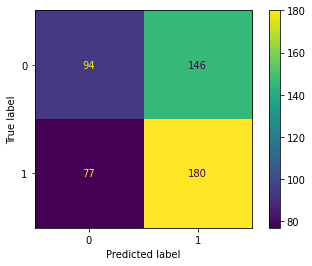

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

print(classification_report(y_val, cbr.predict(val_transf)))
cbr_pred = cbr.predict(val_transf)
cm = confusion_matrix(y_val, cbr_pred, labels=cbr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cbr.classes_)
disp.plot()
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


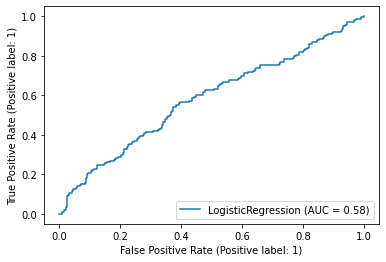

In [ ]:
from sklearn import metrics

metrics.plot_roc_curve(cbr, val_transf, y_val) 
plt.show()

In [ ]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

cbr_pred = cbr.predict(val_transf)
cbr_pred_proba = cbr.predict_proba(val_transf)[:, 1]
mean_thr = cbr.predict_proba(train_transf)[:, 1].mean() # cbr_pred_proba.mean()

printmd('**Classification report with probability threshold at 0.5:**')
print(classification_report(y_val, cbr_pred))
printmd('\n**Classification report with probability threshold at distribution mean:**')
print(classification_report(y_val, np.where(cbr_pred_proba>mean_thr, 1, 0)))

**Classification report with probability threshold at 0.5:**

              precision    recall  f1-score   support

           0       0.55      0.39      0.46       240
           1       0.55      0.70      0.62       257

    accuracy                           0.55       497
   macro avg       0.55      0.55      0.54       497
weighted avg       0.55      0.55      0.54       497




**Classification report with probability threshold at distribution mean:**

              precision    recall  f1-score   support

           0       0.56      0.50      0.53       240
           1       0.57      0.63      0.60       257

    accuracy                           0.57       497
   macro avg       0.56      0.56      0.56       497
weighted avg       0.56      0.57      0.56       497



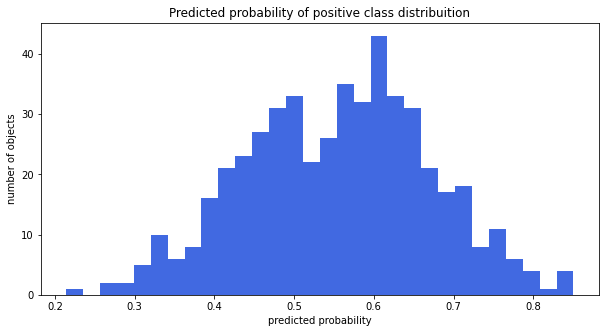

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(cbr.predict_proba(val_transf)[:, 1], bins=30, color='royalblue')
plt.title('Predicted probability of positive class distribuition')
plt.xlabel('predicted probability')
plt.ylabel('number of objects')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


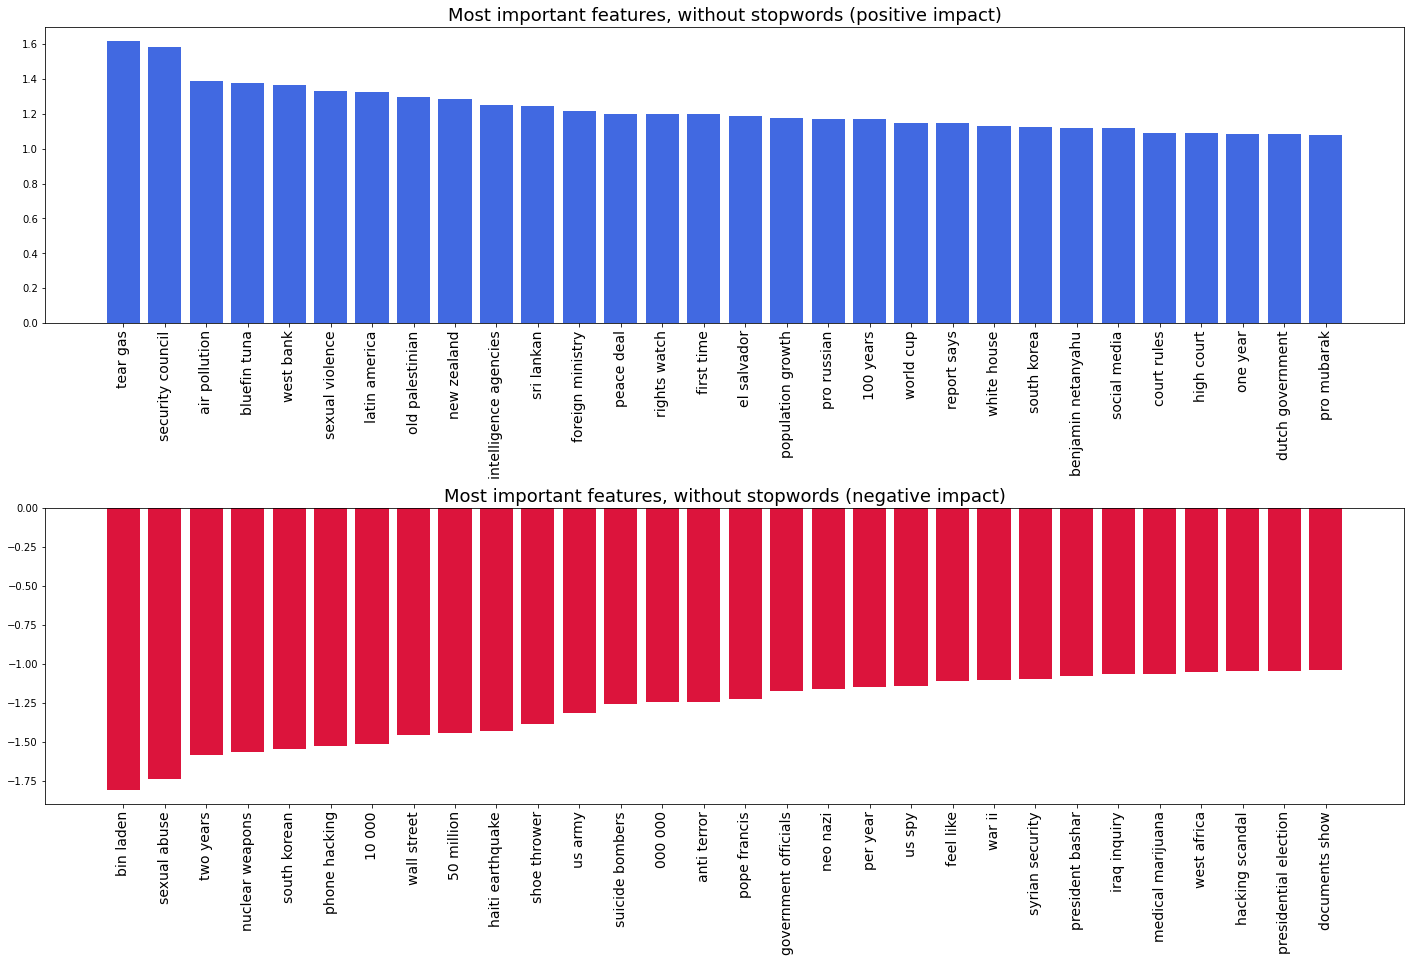

In [ ]:
# важность, очищено от stopwords
tfidf_importances_raw = list(zip(vectorizer.get_feature_names(), cbr.coef_[0]))
nltk_stopwords_set = list(set(stopwords.words('english')))
tfidf_importances = [x for x in tfidf_importances_raw if x[0].split()[0] not in nltk_stopwords_set and x[0].split()[1] not in nltk_stopwords_set]
tfidf_importances_sorted = sorted(tfidf_importances, key=lambda x: x[1], reverse=True)
tfidf_importances_desorted = sorted(tfidf_importances, key=lambda x: x[1])

fig, ax = plt.subplots(2, 1, figsize=(20,12))

fig.tight_layout(pad=2.)
ax[0].bar([x[0] for x in tfidf_importances_sorted[:30]], [x[1] for x in tfidf_importances_sorted[:30]], color='royalblue')
ax[0].set_title('Most important features, without stopwords (positive impact)', size=18)
ax[0].tick_params(labelrotation=90, axis='x', labelsize=14)

fig.tight_layout(pad=2.5)
ax[1].bar([x[0] for x in tfidf_importances_desorted[:30]], [x[1] for x in tfidf_importances_desorted[:30]], color='crimson')
ax[1].set_title('Most important features, without stopwords (negative impact)', size=18)
ax[1].tick_params(labelrotation=90, axis='x', labelsize=14)
plt.show()

In [ ]:
# cnt, bigram_list = 0, []
# for sent in comb_df.headlines_stem:
#   if 'tear gas' in sent:
#     # print(sent)
#     bigram_list.append(sent)
#     cnt += 1
#   if cnt == 10:
#     break

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


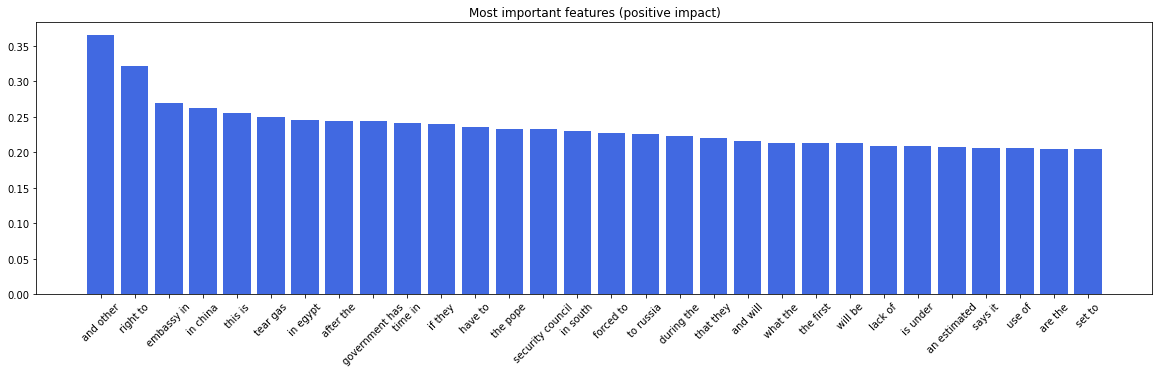

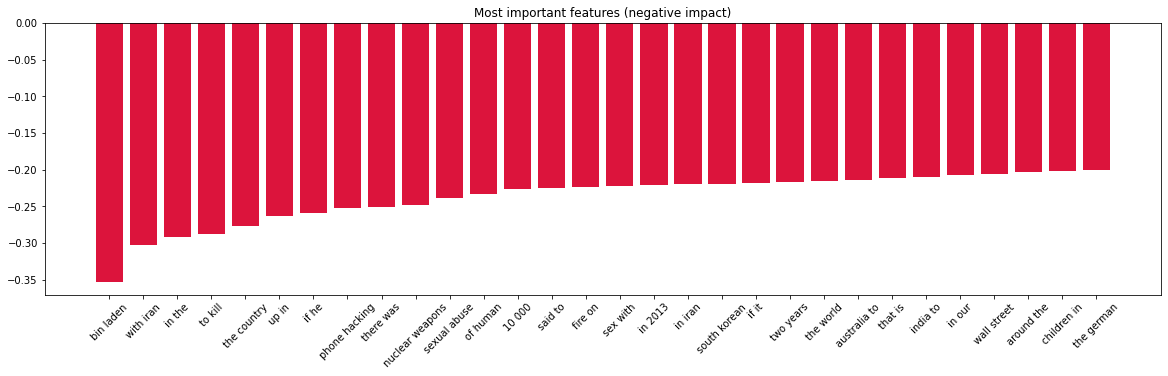

In [ ]:
tfidf_importances = list(zip(vectorizer.get_feature_names(), cbr.coef_[0]))
tfidf_importances_sorted = sorted(tfidf_importances, key=lambda x: x[1], reverse=True)
tfidf_importances_desorted = sorted(tfidf_importances, key=lambda x: x[1])

plt.figure(figsize=(20, 5))
plt.bar([x[0] for x in tfidf_importances_sorted[:30]], [x[1] for x in tfidf_importances_sorted[:30]], color='royalblue')
plt.title('Most important features (positive impact)')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(20, 5))
plt.bar([x[0] for x in tfidf_importances_desorted[:30]], [x[1] for x in tfidf_importances_desorted[:30]], color='crimson')
plt.title('Most important features (negative impact)')
plt.xticks(rotation=45)
plt.show()

### target encoding

In [ ]:
# best baseline on gridsearch
train_transf, val_transf, y_train, y_val, vectorizer, comb_df = preprocessing_data(N_ARTICLES=25,
                                                                                   PREPROC='LEMM',
                                                                                   STOPWORDS=True,
                                                                                   TARGET_DAY='same',
                                                                                   NGRAM=(1,1), 
                                                                                   TFIDF_MAXFEAT=30000)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cnt_vectorizer = CountVectorizer()
cnt_vectorizer_fit = cnt_vectorizer.fit_transform(comb_df.headlines_stem)

list_cv_vocab = list(zip(cnt_vectorizer.get_feature_names_out(), cnt_vectorizer_fit.toarray().sum(axis=0)))
list_cv_vocab_sorted = sorted(list_cv_vocab, key=lambda x: x[1], reverse=True)

In [ ]:
num_feat = comb_df[['headlines_concat', 'weekday', 'year', 'month_text', # 'quarter', 
       'Open', 'High', 'Low', 'Close', 'Volume','Close_trailing5', 
       'Close_trailing30','Volume_trailing5', 'Volume_trailing30', 'Close_maxmin5', 
       'Close_maxmin30', 'Close_rate2', 'Close_rate5', 'Close_rate30', 'Label']]
num_feat[['weekday', 'year', 'month_text']] = num_feat[['weekday', 'year', 'month_text']].astype(object)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
list_cv_vocab_sorted[:10]

N_WORD_TARGET_FEATURES = 100
for w, i in list_cv_vocab_sorted[:N_WORD_TARGET_FEATURES]:
  num_feat[w] = num_feat.headlines_concat.apply(lambda sent_list: 1 if w in sent_list else 0).astype(object)

num_feat = num_feat.drop(columns='headlines_concat')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """


In [ ]:
val_thr = len(num_feat) - (len(num_feat) // 4)
X_train, X_val, y_train, y_val = num_feat.drop(columns='Label')[:val_thr], num_feat.drop(columns='Label')[val_thr:], num_feat.Label[:val_thr], num_feat.Label[val_thr:]

In [ ]:
from catboost import CatBoostClassifier

cat_feat = list(num_feat.columns[num_feat.dtypes==object])
cbr = CatBoostClassifier(iterations=500, max_depth=6, cat_features=cat_feat) # ,learning_rate=1
cbr.fit(X_train, y_train, silent=True)

cbr_pred = cbr.predict(X_val)
cbr_pred_proba = cbr.predict_proba(X_val)[:, 1]
mean_thr = cbr_pred_proba.mean()
print('Validation accuracy: {}'.format(accuracy_score(y_val, cbr_pred)))
print('Validation accuracy w threshold: {}'.format(accuracy_score(y_val, np.where(cbr_pred_proba>mean_thr, 1, 0))))
print('Validation precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_val, cbr_pred, average='binary')))
print('Validation roc_auc_score: {}'.format(roc_auc_score(y_val, cbr_pred_proba)))
print(cbr_pred.sum() / X_val.shape[0])

cbr_pred = cbr.predict(X_train)
cbr_pred_proba = cbr.predict_proba(X_train)[:, 1]
mean_thr = cbr_pred_proba.mean()
print('Validation accuracy: {}'.format(accuracy_score(y_train, cbr_pred)))
print('Validation accuracy w threshold: {}'.format(accuracy_score(y_train, np.where(cbr_pred_proba>mean_thr, 1, 0))))
print('Validation precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_train, cbr_pred, average='binary')))
print('Validation roc_auc_score: {}'.format(roc_auc_score(y_train, cbr_pred_proba)))
print(cbr_pred.sum() / X_train.shape[0])

Validation accuracy: 0.5070422535211268
Validation accuracy w threshold: 0.5251509054325956
Validation precision_recall_fscore_support: (0.5174418604651163, 0.6926070038910506, 0.5923460898502496, None)
Validation roc_auc_score: 0.5150291828793774
0.6921529175050302
Validation accuracy: 0.9705093833780161
Validation accuracy w threshold: 0.9859249329758714
Validation precision_recall_fscore_support: (0.9483568075117371, 1.0, 0.9734939759036145, None)
Validation roc_auc_score: 0.9989994065195993
0.5710455764075067


In [ ]:
# plt.bar(X_train.columns, cbr.feature_importances_)
cbr.feature_importances_

array([10.45321893,  9.14393284,  9.84883366,  3.67155219,  2.40157336,
        2.61406607,  3.1532941 ,  8.20151293,  2.89122018,  2.99370485,
        4.88100532,  6.16086388,  3.33579691,  5.13988588, 10.84355363,
        6.94161634,  7.32436893])

### texts + fin ensemble

In [ ]:
from keras import regularizers, optimizers
from keras.models import Sequential
from keras.layers import TextVectorization, Embedding, Dense, Input, LSTM, Lambda, Softmax, Dropout, GlobalMaxPool1D
from keras.initializers import Constant
from keras import backend
import tensorflow as tf
import spacy
import gensim.downloader as api
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

In [ ]:
# TOUSEEMBEDDINGS IN NEXT CELL (in vectorize texts)

# # best baseline on gridsearch
# train_transf, val_transf, y_train, y_val, vectorizer, comb_df = preprocessing_data(N_ARTICLES=25,
#                                                                                    PREPROC=None,
#                                                                                    STOPWORDS=False,
#                                                                                    TARGET_DAY='same',
#                                                                                    NGRAM=(2,2), 
#                                                                                    TFIDF_MAXFEAT=30000)

# # linguistic model
# w2v = api.load('word2vec-google-news-300')
# # w2v_sentences = comb_df.headlines_stem.apply(lambda x: x.split())
# # w2v = Word2Vec(sentences=w2v_sentences, size=32, window=5, min_count=1, workers=4) # common_texts

# # build vocab
# spacy_nlp = spacy.load("en_core_web_sm")
# textVectorizer = TextVectorization(max_tokens=50000)
# text = pd.DataFrame(comb_df.headlines_stem)
# textVectorizer.adapt(text.to_numpy())
# vocab = textVectorizer.get_vocabulary()

# # embedding matrix
# skip_vocab = list(map(str, vocab))
# num_tokens = len(skip_vocab)
# embedding_dim = len(w2v.wv['word']) # len(spacy_nlp('word').vector) # len(w2v['word'])
# embedding_matrix = np.zeros((num_tokens, embedding_dim))
# null_check_cnt = 0
# for i, word in enumerate(skip_vocab): 
#   if i%3000==0: 
#     print(i, word, end='; ')
  
#   if word=='' or word=='[UNK]':
#     null_check_cnt+=1
#     embedding_matrix[i] = np.zeros(w2v.wv['word'].shape) # np.zeros(spacy_nlp('word').vector.shape) # np.zeros(w2v['word'].shape)
#   else: 
#     if word in w2v.wv: # spacy_nlp.vocab: # w2v:
#       embedding_matrix[i] = w2v.wv[word]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


0 ; 3000 36; 6000 unlawfully; 9000 theories; 12000 touted; 15000 gamma; 18000 magnus; 21000 wangaratta; 24000 rekha; 27000 mahilal; 30000 faecal; 33000 barbie; 

In [ ]:
# best baseline on gridsearch
train_transf, val_transf, y_train, y_val, vectorizer, comb_df = preprocessing_data(N_ARTICLES=25,
                                                                                   PREPROC=None,
                                                                                   STOPWORDS=False,
                                                                                   TARGET_DAY='same',
                                                                                   NGRAM=(2,2), 
                                                                                   TFIDF_MAXFEAT=30000)

# split data
val_thr = len(comb_df) - (len(comb_df) // 4)
fin_feat = list(comb_df.columns[44:53]) + ['year', 'month'] + ['Open','High','Low','Close','Volume']
comb_df_fin = comb_df[fin_feat] # CHECK fin_feat
X_train, X_val, y_train, y_val = comb_df.headlines_stem[:val_thr], comb_df.headlines_stem[val_thr:], comb_df.Label[:val_thr], comb_df.Label[val_thr:]
X_train_fin, X_val_fin = comb_df_fin[:val_thr], comb_df_fin[val_thr:]

# vectorize texts
# vectorizer = TfidfVectorizer(ngram_range=(2,2), max_features=None)
# train_transf = vectorizer.fit_transform(X_train)
# val_transf = vectorizer.transform(X_val)

w2v_sentences = comb_df.headlines_stem.apply(lambda x: x.split())
w2v = Word2Vec(sentences=w2v_sentences, size=98, window=5, min_count=5, workers=4)

train_transf = X_train.apply(lambda x: np.array([w2v.wv[word] for word in x.split() if word in w2v.wv]).mean(axis=0))
val_transf = X_val.apply(lambda x: np.array([w2v.wv[word] for word in x.split() if word in w2v.wv]).mean(axis=0))
train_transf = pd.DataFrame(np.vstack(train_transf))
val_transf = pd.DataFrame(np.vstack(val_transf))

# scale fin
ssc = StandardScaler()
X_train_fin = pd.DataFrame(ssc.fit_transform(X_train_fin), columns=X_train_fin.columns)
X_val_fin = pd.DataFrame(ssc.transform(X_val_fin), columns=X_train_fin.columns)

KeyError: ignored

In [ ]:
train_transf.shape, X_train_fin.shape
# pd.merge(left=train_transf, right=X_train_fin, how='cross').head()

In [ ]:
# model
from catboost import CatBoostClassifier

# cbr = LogisticRegression(C=1, max_iter=1000) # C=10
# cbr.fit(train_transf, y_train)
cbr = CatBoostClassifier(iterations=100, max_depth=6, learning_rate=1)
cbr.fit(train_transf, y_train, silent=True)

In [ ]:
cbr_pred = cbr.predict(train_transf)
cbr_pred_proba = cbr.predict_proba(train_transf)
print('Train accuracy: {}'.format(accuracy_score(y_train, cbr_pred)))
print('Train precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_train, cbr_pred, average='binary')))
print('Train roc_auc_score: {}'.format(roc_auc_score(y_train, cbr_pred_proba[:, 1])))
print(cbr_pred.sum() / train_transf.shape[0])

cbr_pred = cbr.predict(val_transf)
cbr_pred_proba = cbr.predict_proba(val_transf)
# cbr_pred = np.where(cbr.predict_proba(val_transf)[:, 1]>0.5, 1, 0)
print('\nValidation accuracy: {}'.format(accuracy_score(y_val, cbr_pred)))
print('Validation precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_val, cbr_pred, average='binary')))
print('Validation roc_auc_score: {}'.format(roc_auc_score(y_val, cbr_pred_proba[:, 1])))
print(cbr_pred.sum() / val_transf.shape[0])

Train accuracy: 0.7466487935656837
Train precision_recall_fscore_support: (0.6815878378378378, 0.9987623762376238, 0.8102409638554217, None)
Train roc_auc_score: 0.9718205373168896
0.7935656836461126

Validation accuracy: 0.5392354124748491
Validation precision_recall_fscore_support: (0.5296610169491526, 0.9727626459143969, 0.6858710562414266, None)
Validation roc_auc_score: 0.5243352788586252
0.9496981891348089


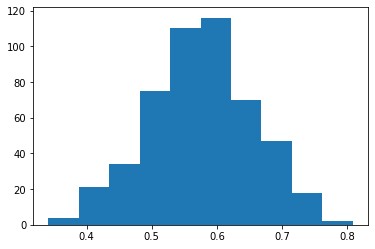

In [ ]:
plt.hist(cbr_pred_proba[:, 1])
plt.show()

In [ ]:
### model

# text model
cbr_text = LogisticRegression(C=10, max_iter=1000) # C=10
cbr_text.fit(train_transf, y_train)
cbr_text_val = cbr_text.predict_proba(val_transf)[:, 1]

# fin model
cbr_fin = LogisticRegression(C=10, max_iter=1000) # C=10
# cbr_fin = CatBoostClassifier(iterations=100,max_depth=4) # ,learning_rate=1
cbr_fin.fit(X_train_fin, y_train)
cbr_fin_val = cbr_fin.predict_proba(X_val_fin)[:, 1]

# ensemble
train_ens = pd.DataFrame()
train_ens['text'] = cbr_text.predict_proba(train_transf)[:, 1]
train_ens['fin'] = cbr_fin.predict_proba(X_train_fin)[:, 1]
cbr_ens = LogisticRegression(C=10, max_iter=100)
cbr_ens.fit(train_ens, y_train)

val_ens = pd.DataFrame()
val_ens['text'] = cbr_text_val
val_ens['fin'] = cbr_fin_val

# validate
cbr_ens_pred = cbr_ens.predict(val_ens)
cbr_ens_pred_proba = cbr_ens.predict_proba(val_ens)
print('Validation accuracy: {}'.format(accuracy_score(y_val, cbr_ens_pred)))
print('Validation precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_val, cbr_ens_pred, average='binary')))
print('Validation roc_auc_score: {}'.format(roc_auc_score(y_val, cbr_ens_pred_proba[:, 1])))
print(cbr_ens_pred.sum() / val_ens.shape[0])

Validation accuracy: 0.5070422535211268
Validation precision_recall_fscore_support: (0.5171428571428571, 0.7042801556420234, 0.5963756177924218, None)
Validation roc_auc_score: 0.502837224383917
0.704225352112676


### w2v + catboost

In [ ]:
from keras import regularizers, optimizers
from keras.models import Sequential
from keras.layers import TextVectorization, Embedding, Dense, Input, LSTM, Lambda, Softmax, Dropout, GlobalMaxPool1D
from keras.initializers import Constant
from keras import backend
import tensorflow as tf
import spacy
import gensim.downloader as api
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

# train_transf, val_transf, y_train, y_val, vectorizer, comb_df = preprocessing_data(N_ARTICLES=25,
#                                                                                    PREPROC='LEMM',
#                                                                                    STOPWORDS=False,
#                                                                                    TARGET_DAY='same',
#                                                                                    NGRAM=(2,2), 
#                                                                                    TFIDF_MAXFEAT=None)

In [ ]:
# # try to double the dataset

# # best baseline on gridsearch
# train_transf, val_transf, y_train, y_val, vectorizer, comb_df = preprocessing_data(N_ARTICLES=25,
#                                                                                    PREPROC='LEMM',
#                                                                                    STOPWORDS=False,
#                                                                                    TARGET_DAY='same',
#                                                                                    NGRAM=(2,2), 
#                                                                                    TFIDF_MAXFEAT=None)
# # headline concatenation
# # first 10 headlines
# for i in range(1, 10+1):
#   if i == 1:
#       comb_df['headlines10_concat'] = comb_df['Top1'].apply(CountVectorizer().build_tokenizer())
#   else:
#       comb_df['headlines10_concat'] += comb_df['Top'+str(i)].apply(CountVectorizer().build_tokenizer())
# # 10-25 headlines
# for i in range(11, 25+1):
#   if i == 11:
#       comb_df['headlines15_concat'] = comb_df['Top11'].apply(CountVectorizer().build_tokenizer())
#   else:
#       comb_df['headlines15_concat'] += comb_df['Top'+str(i)].apply(CountVectorizer().build_tokenizer())

# # text preprocessing
# stemmer = SnowballStemmer('english')
# lemmatizer = WordNetLemmatizer()
# nltk_stopwords_set = list(set(stopwords.words('english')))

# comb_df['headlines10_stem'] = comb_df['headlines10_concat'].apply(lambda sent: ' '.join([
#     lemmatizer.lemmatize(w.lower()) for w in sent 
#     if w.lower() not in nltk_stopwords_set 
#     and w not in punctuation]))
# comb_df['headlines15_stem'] = comb_df['headlines15_concat'].apply(lambda sent: ' '.join([
#     lemmatizer.lemmatize(w.lower()) for w in sent 
#     if w.lower() not in nltk_stopwords_set 
#     and w not in punctuation]))

# comb_df = pd.concat([comb_df[['headlines10_stem', 'Label']].rename(columns={"headlines10_stem": "headlines_stem"}), 
#            comb_df[['headlines15_stem', 'Label']].rename(columns={"headlines15_stem": "headlines_stem"})]).reset_index(drop=True)

In [ ]:
# try to tIMES 5 the dataset

# best baseline on gridsearch
train_transf, val_transf, y_train, y_val, vectorizer, comb_df = preprocessing_data(N_ARTICLES=25,
                                                                                   PREPROC='LEMM',
                                                                                   STOPWORDS=False,
                                                                                   TARGET_DAY='same',
                                                                                   NGRAM=(2,2), 
                                                                                   TFIDF_MAXFEAT=None)

## NEXT DAY TARGET
comb_df = comb_df.sort_values('Date')
comb_df['Label'] = list(comb_df['Label'])[1:] + [0]
## ###

# headline concatenation
for j in range(5):
  for i in range(j*5+1, j*5+5+1):
    if i%5 == 1:
        comb_df['headlines'+str(j)+'_concat'] = comb_df['Top'+str(i)].apply(CountVectorizer().build_tokenizer())
    else:
        comb_df['headlines'+str(j)+'_concat'] += comb_df['Top'+str(i)].apply(CountVectorizer().build_tokenizer())

# text preprocessing
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
nltk_stopwords_set = list(set(stopwords.words('english')))

for j in range(5):
  comb_df['headlines'+str(j)+'_stem'] = comb_df['headlines'+str(j)+'_concat'].apply(lambda sent: ' '.join([
    lemmatizer.lemmatize(w.lower()) for w in sent 
    if w.lower() not in nltk_stopwords_set 
    and w not in punctuation]))

comb_df = pd.concat([comb_df[['headlines0_stem', 'Label', 'Date']].rename(columns={"headlines0_stem": "headlines_stem"}),
                     comb_df[['headlines1_stem', 'Label', 'Date']].rename(columns={"headlines1_stem": "headlines_stem"}),
                     comb_df[['headlines2_stem', 'Label', 'Date']].rename(columns={"headlines2_stem": "headlines_stem"}),
                     comb_df[['headlines3_stem', 'Label', 'Date']].rename(columns={"headlines3_stem": "headlines_stem"}),
                     comb_df[['headlines4_stem', 'Label', 'Date']].rename(columns={"headlines4_stem": "headlines_stem"})]).reset_index(drop=True)

comb_df = comb_df.sort_values(by='Date', ascending=True).drop(columns=['Date']).reset_index(drop=True)

In [ ]:
# pd.concat([comb_df.head(), comb_df.head(), comb_df.head()])
# comb_df.head()
comb_df.shape

(9945, 2)

In [ ]:
# linguistic model
# w2v = api.load('word2vec-google-news-300')
w2v_sentences = comb_df.headlines_stem.apply(lambda x: x.split())
w2v = Word2Vec(sentences=w2v_sentences, size=100, window=5, min_count=5, workers=4) # common_texts


### TRY word2vec-google-news-300 ???

# build vocab
spacy_nlp = spacy.load("en_core_web_sm")
textVectorizer = TextVectorization(max_tokens=50000)
text = pd.DataFrame(comb_df.headlines_stem)
textVectorizer.adapt(text.to_numpy())
vocab = textVectorizer.get_vocabulary()

In [ ]:
# embedding matrix
skip_vocab = list(map(str, vocab))
num_tokens = len(skip_vocab)
embedding_dim = len(w2v.wv['word']) # len(spacy_nlp('word').vector) # len(w2v['word'])
embedding_matrix = np.zeros((num_tokens, embedding_dim))

headlines_emb = comb_df.headlines_stem.apply(lambda x: np.array([w2v.wv[word] for word in x.split() if word in w2v.wv]).mean(axis=0))
headlines_emb = pd.DataFrame(np.vstack(headlines_emb))

# headlines_emb = np.empty((len(w2v_sentences), embedding_dim), dtype=object)
# for i in range(len(headlines_emb)):
#   if i%300==0: 
#     print(i, end='; ')
  
#   doc_emb = np.zeros(embedding_dim)
#   for word in w2v_sentences[i]:
#     if word in w2v.wv: # spacy_nlp.vocab: # w2v:
#       doc_emb += w2v.wv[word]
  
#   headlines_emb[i] = doc_emb / len(w2v_sentences[i])

In [ ]:
headlines_emb.shape
# headlines_emb.reshape(headlines_emb.shape[0], embedding_dim)
# list(headlines_emb[0])

(9945, 100)

In [ ]:
val_thr = len(headlines_emb) - (len(headlines_emb) // 5)
X_train, X_val, y_train, y_val = headlines_emb[:val_thr], headlines_emb[val_thr:], comb_df.Label[:val_thr], comb_df.Label[val_thr:]

In [ ]:
# model
from catboost import CatBoostClassifier

# cbr = LogisticRegression(C=10, max_iter=1000) # C=10
# cbr.fit(X_train, y_train)
cbr = CatBoostClassifier(iterations=1000, max_depth=4) # ,learning_rate=1
cbr.fit(X_train, y_train, silent=True)

In [ ]:
cbr_pred = cbr.predict(X_val)
cbr_pred_proba = cbr.predict_proba(X_val)
print('Validation accuracy: {}'.format(accuracy_score(y_val, cbr_pred)))
print('Validation precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_val, cbr_pred, average='binary')))
print('Validation roc_auc_score: {}'.format(roc_auc_score(y_val, cbr_pred_proba[:, 1])))
print(cbr_pred.sum() / X_val.shape[0])

cbr_pred = cbr.predict(X_train)
cbr_pred_proba = cbr.predict_proba(X_train)
print('\nTrain accuracy: {}'.format(accuracy_score(y_train, cbr_pred)))
print('Train precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_train, cbr_pred, average='binary')))
print('Train roc_auc_score: {}'.format(roc_auc_score(y_train, cbr_pred_proba[:, 1])))

Validation accuracy: 0.5113122171945701
Validation precision_recall_fscore_support: (0.510116492949111, 0.8278606965174129, 0.6312594840667679, None)
Validation roc_auc_score: 0.516204546373822
0.8200100553041729

Train accuracy: 0.7596782302664655
Train precision_recall_fscore_support: (0.7010688042752171, 0.9717592592592592, 0.8145129996119519, None)
Train roc_auc_score: 0.9066111009249073


In [ ]:
cbr_pred = cbr.predict(X_val)
cbr_pred_proba = cbr.predict_proba(X_val)
print('Validation accuracy: {}'.format(accuracy_score(y_val, cbr_pred)))
print('Validation precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_val, cbr_pred, average='binary')))
print('Validation roc_auc_score: {}'.format(roc_auc_score(y_val, cbr_pred_proba[:, 1])))
print(cbr_pred.sum() / X_val.shape[0])

cbr_pred = cbr.predict(X_train)
cbr_pred_proba = cbr.predict_proba(X_train)
print('\nTrain accuracy: {}'.format(accuracy_score(y_train, cbr_pred)))
print('Train precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_train, cbr_pred, average='binary')))
print('Train roc_auc_score: {}'.format(roc_auc_score(y_train, cbr_pred_proba[:, 1])))

Validation accuracy: 0.5540472599296129
Validation precision_recall_fscore_support: (0.5624123422159888, 0.7530516431924883, 0.6439181051786431, None)
Validation roc_auc_score: 0.5651108672235433
0.7169431875314228

Train accuracy: 0.8880090497737556
Train precision_recall_fscore_support: (0.8391383128649084, 0.9784037558685446, 0.9034355695242223, None)
Train roc_auc_score: 0.9768544346889417


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


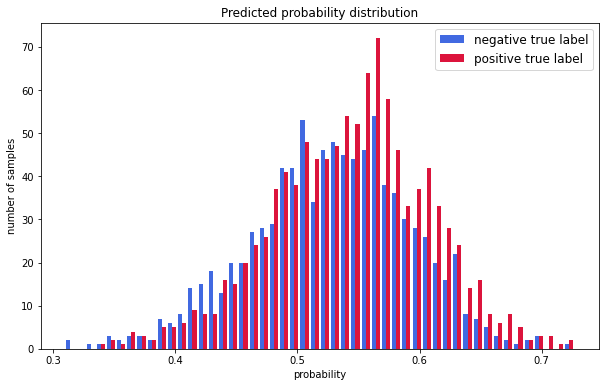

In [ ]:
plt.figure(figsize=(10, 6))
# plt.hist(cbr_pred_proba[:, 1], bins=30, color='royalblue', label='Word2Vec + catboost') 
plt.hist([cbr_pred_proba[:, 1][y_val==0], cbr_pred_proba[:, 1][y_val==1]], 
         color=['royalblue', 'crimson'], 
         label=['negative true label', 'positive true label'], bins=50)
plt.title('Predicted probability distribution')
plt.xlabel('probability')
plt.ylabel('number of samples')
plt.legend(prop={'size': 12})
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


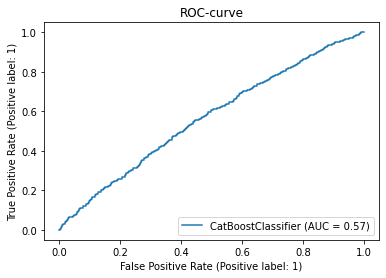

In [ ]:
from IPython.display import Markdown, display
from sklearn.metrics import classification_report
from sklearn import metrics

metrics.plot_roc_curve(cbr, X_val, y_val) 
plt.title('ROC-curve')
plt.show()

In [ ]:
def printmd(string):
    display(Markdown(string))

cbr_pred = cbr.predict(X_val)
cbr_pred_proba = cbr.predict_proba(X_val)[:, 1]
mean_thr = cbr.predict_proba(X_train)[:, 1].mean() # cbr_pred_proba.mean()

printmd('**Classification report with probability threshold at 0.5:**')
print(classification_report(y_val, cbr_pred))
printmd('\n**Classification report with probability threshold at distribution mean:**')
print(classification_report(y_val, np.where(cbr_pred_proba>mean_thr, 1, 0)))

**Classification report with probability threshold at 0.5:**

              precision    recall  f1-score   support

           0       0.53      0.32      0.40       924
           1       0.56      0.75      0.64      1065

    accuracy                           0.55      1989
   macro avg       0.55      0.54      0.52      1989
weighted avg       0.55      0.55      0.53      1989




**Classification report with probability threshold at distribution mean:**

              precision    recall  f1-score   support

           0       0.52      0.53      0.52       924
           1       0.58      0.57      0.58      1065

    accuracy                           0.55      1989
   macro avg       0.55      0.55      0.55      1989
weighted avg       0.55      0.55      0.55      1989



In [ ]:
# print(''w2v.wv.similarity('france', 'spain')
w2v['man'].shape

from numpy import dot
from numpy.linalg import norm
def cos_sim(a,b):
  return dot(a, b)/(norm(a)*norm(b))

w2v.similarity('france', 'spain'), cos_sim(w2v['france'], w2v['spain'])
w2v.similarity('bull', 'stock')

0.27776054

In [ ]:
comb_df.headlines_stem[:10]

0    georgia down two russian warplane country move...
1    wont america nato help u wont help u help iraq...
2    remember adorable year old sang opening ceremo...
3    refuse israel weapon attack iran report presid...
4    expert admit legalise drug war south osetia 89...
5    mom missing gay man bad 21 year old cheerleade...
6    afghan prison majority female prisoner serving...
7    man arrested locked five hour taking photo pol...
8    two elderly chinese woman sentenced year educa...
9    british resident held guantanamo bay win legal...
Name: headlines_stem, dtype: object

In [ ]:
q = w2v['queen']
qq = w2v['king'] - w2v['man'] + w2v['woman']

cos_sim(q, qq)

0.73005176

#### new w2v ???

In [ ]:
# import gensim
# from gensim.models import word2vec
# from gensim.models import KeyedVectors
# from sklearn.metrics.pairwise import cosine_similarity

# !wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
# EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
# w2v = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

### LSTM

In [ ]:
from keras import regularizers, optimizers
from keras.models import Sequential
from keras.layers import TextVectorization, Embedding, Dense, Input, LSTM, Lambda, Softmax, Dropout, GlobalMaxPool1D
from keras.initializers import Constant
from keras import backend
import tensorflow as tf
import spacy
import gensim.downloader as api
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from keras.layers import Conv2D, Conv1D

In [ ]:
train_transf, val_transf, y_train, y_val, vectorizer, comb_df = preprocessing_data(N_ARTICLES=25,
                                                                                   PREPROC='LEMM', # None,
                                                                                   STOPWORDS=True,
                                                                                   TARGET_DAY='same',
                                                                                   NGRAM=(2,2), 
                                                                                   TFIDF_MAXFEAT=None) # 30000

In [ ]:
# # try to double the dataset

# # headline concatenation
# # first 10 headlines
# for i in range(1, 10+1):
#   if i == 1:
#       comb_df['headlines10_concat'] = comb_df['Top1'].apply(CountVectorizer().build_tokenizer())
#   else:
#       comb_df['headlines10_concat'] += comb_df['Top'+str(i)].apply(CountVectorizer().build_tokenizer())
# # 10-25 headlines
# for i in range(11, 25+1):
#   if i == 11:
#       comb_df['headlines15_concat'] = comb_df['Top11'].apply(CountVectorizer().build_tokenizer())
#   else:
#       comb_df['headlines15_concat'] += comb_df['Top'+str(i)].apply(CountVectorizer().build_tokenizer())

# # text preprocessing
# stemmer = SnowballStemmer('english')
# lemmatizer = WordNetLemmatizer()
# nltk_stopwords_set = list(set(stopwords.words('english')))

# comb_df['headlines10_stem'] = comb_df['headlines10_concat'].apply(lambda sent: ' '.join([
#     lemmatizer.lemmatize(w.lower()) for w in sent 
#     if w.lower() not in nltk_stopwords_set 
#     and w not in punctuation]))
# comb_df['headlines15_stem'] = comb_df['headlines15_concat'].apply(lambda sent: ' '.join([
#     lemmatizer.lemmatize(w.lower()) for w in sent 
#     if w.lower() not in nltk_stopwords_set 
#     and w not in punctuation]))

# comb_df = pd.concat([comb_df[['headlines10_stem', 'Label']].rename(columns={"headlines10_stem": "headlines_stem"}), 
#            comb_df[['headlines15_stem', 'Label']].rename(columns={"headlines15_stem": "headlines_stem"})])

In [ ]:
# try to tIMES 5 the dataset

# best baseline on gridsearch
train_transf, val_transf, y_train, y_val, vectorizer, comb_df = preprocessing_data(N_ARTICLES=25,
                                                                                   PREPROC='LEMM',
                                                                                   STOPWORDS=True,
                                                                                   TARGET_DAY='same',
                                                                                   NGRAM=(2,2), 
                                                                                   TFIDF_MAXFEAT=None)

## NEXT DAY TARGET
# comb_df = comb_df.sort_values('Date')
# comb_df['Label'] = list(comb_df['Label'])[1:] + [0]
## ###

# headline concatenation
for j in range(5):
  for i in range(j*5+1, j*5+5+1):
    if i%5 == 1:
        comb_df['headlines'+str(j)+'_concat'] = comb_df['Top'+str(i)].apply(CountVectorizer().build_tokenizer())
    else:
        comb_df['headlines'+str(j)+'_concat'] += comb_df['Top'+str(i)].apply(CountVectorizer().build_tokenizer())

# text preprocessing
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
nltk_stopwords_set = list(set(stopwords.words('english')))

for j in range(5):
  comb_df['headlines'+str(j)+'_stem'] = comb_df['headlines'+str(j)+'_concat'].apply(lambda sent: ' '.join([
    lemmatizer.lemmatize(w.lower()) for w in sent 
    if w.lower() not in nltk_stopwords_set 
    and w not in punctuation]))

comb_df = pd.concat([comb_df[['headlines0_stem', 'Label', 'Date']].rename(columns={"headlines0_stem": "headlines_stem"}),
                     comb_df[['headlines1_stem', 'Label', 'Date']].rename(columns={"headlines1_stem": "headlines_stem"}),
                     comb_df[['headlines2_stem', 'Label', 'Date']].rename(columns={"headlines2_stem": "headlines_stem"}),
                     comb_df[['headlines3_stem', 'Label', 'Date']].rename(columns={"headlines3_stem": "headlines_stem"}),
                     comb_df[['headlines4_stem', 'Label', 'Date']].rename(columns={"headlines4_stem": "headlines_stem"})]).reset_index(drop=True)

comb_df = comb_df.sort_values(by='Date', ascending=True).drop(columns=['Date']).reset_index(drop=True)

In [ ]:
# linguistic model
w2v = api.load('word2vec-google-news-300')
# w2v_sentences = comb_df.headlines_stem.apply(lambda x: x.split())
# w2v = Word2Vec(sentences=w2v_sentences, size=300, window=5, min_count=1, workers=4) # common_texts

# build vocab
spacy_nlp = spacy.load("en_core_web_sm")
textVectorizer = TextVectorization(max_tokens=10000) # 50000)
text = pd.DataFrame(comb_df.headlines_stem)
textVectorizer.adapt(text.to_numpy())
vocab = textVectorizer.get_vocabulary()

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# embedding matrix
skip_vocab = list(map(str, vocab))
num_tokens = len(skip_vocab)
embedding_dim = len(w2v.wv['word']) # len(spacy_nlp('word').vector) # len(w2v['word'])
embedding_matrix = np.zeros((num_tokens, embedding_dim))
null_check_cnt = 0
for i, word in enumerate(skip_vocab): 
  if i%3000==0: 
    print(i, word, end='; ')
  
  if word=='' or word=='[UNK]':
    null_check_cnt+=1
    embedding_matrix[i] = np.zeros(w2v.wv['word'].shape) # np.zeros(spacy_nlp('word').vector.shape) # np.zeros(w2v['word'].shape)
  else: 
    if word in w2v.wv: # spacy_nlp.vocab: # w2v:
      embedding_matrix[i] = w2v.wv[word] # spacy_nlp(word).vector # w2v[word]

Embedding_layer = Embedding(
    num_tokens, 
    embedding_dim, 
    embeddings_initializer=Constant(embedding_matrix), 
    trainable=False)

0 ; 3000 reaction; 6000 comeback; 9000 concentrate; 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()


In [ ]:
# w2v.wv.similarity('france', 'spain')
# zero embeddings
(embedding_matrix.sum(axis=1) == 0).sum() / embedding_matrix.shape[0]

0.0902

In [ ]:
# model
model = Sequential()
model.add(Input(shape=(1,), dtype=tf.string))
model.add(textVectorizer)
model.add(Embedding_layer)
model.add(LSTM(16, return_sequences=True))
# model.add(Conv1D(8, 3))
# model.add(Lambda(lambda x: backend.mean(x, axis=1)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # l1=1e-5, l2=1e-4
model.add(Dense(1, activation='sigmoid')) # tf.keras.activations.softmax))

adam = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_func = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=adam, loss=loss_func, metrics=['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_6 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, None, 300)         3000000   
                                                                 
 lstm_6 (LSTM)               (None, None, 16)          20288     
                                                                 
 global_max_pooling1d_6 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_6 (Dropout)         (None, 16)                0         
                                                                 
 dense_12 (Dense)            (None, 8)                

In [ ]:
val_thr = len(comb_df) - (len(comb_df) // 6)
X_train, X_val, y_train, y_val = comb_df.headlines_stem[:val_thr], comb_df.headlines_stem[val_thr:], comb_df.Label[:val_thr], comb_df.Label[val_thr:]
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((8288,), (1657,), (8288,), (1657,))

In [ ]:
model_history = model.fit(X_train, #.reset_index(), 
                          y_train, 
                          batch_size=16, 
                          epochs=20, # 30
                          validation_split=0.1)

Epoch 1/20
467/467 [==============================] - 14s 30ms/step - loss: 0.2786 - accuracy: 0.8784 - val_loss: 1.3621 - val_accuracy: 0.5115
Epoch 2/20
467/467 [==============================] - 14s 29ms/step - loss: 0.2794 - accuracy: 0.8815 - val_loss: 1.3636 - val_accuracy: 0.5090
Epoch 3/20
467/467 [==============================] - 14s 29ms/step - loss: 0.2522 - accuracy: 0.8930 - val_loss: 1.4238 - val_accuracy: 0.5127
Epoch 4/20
467/467 [==============================] - 14s 29ms/step - loss: 0.2898 - accuracy: 0.8749 - val_loss: 1.4597 - val_accuracy: 0.5090
Epoch 5/20
467/467 [==============================] - 14s 29ms/step - loss: 0.2564 - accuracy: 0.8864 - val_loss: 1.4688 - val_accuracy: 0.5151
Epoch 6/20
467/467 [==============================] - 14s 29ms/step - loss: 0.2614 - accuracy: 0.8855 - val_loss: 1.4250 - val_accuracy: 0.5211
Epoch 7/20
467/467 [==============================] - 14s 29ms/step - loss: 0.2605 - accuracy: 0.8903 - val_loss: 1.4845 - val_accuracy:

In [ ]:
lstm_pred_proba = model.predict(X_train)
lstm_pred = np.where(lstm_pred_proba>0.5, 1, 0)
print('Train accuracy: {}'.format(accuracy_score(y_train, lstm_pred)))
print('Train precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_train, lstm_pred, average='binary')))
print('Train roc_auc_score: {}'.format(roc_auc_score(y_train, lstm_pred_proba)))
print(lstm_pred.sum() / X_train.shape[0])

lstm_pred_proba = model.predict(X_val)
lstm_pred = np.where(lstm_pred_proba>0.5, 1, 0) # lstm_pred_proba.mean()
print('Validation accuracy: {}'.format(accuracy_score(y_val, lstm_pred)))
print('Validation precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_val, lstm_pred, average='binary')))
print('Validation roc_auc_score: {}'.format(roc_auc_score(y_val, lstm_pred_proba)))
print(lstm_pred.sum() / X_val.shape[0])

Train accuracy: 0.9355694980694981
Train precision_recall_fscore_support: (0.9214011106364801, 0.9629464285714285, 0.9417157825802226, None)
Train roc_auc_score: 0.9645270412852642
0.5649131274131274
Validation accuracy: 0.5003017501508751
Validation precision_recall_fscore_support: (0.5083743842364532, 0.6106508875739645, 0.5548387096774193, None)
Validation roc_auc_score: 0.5114160375433585
0.6125528062764032


In [ ]:
lstm_pred_proba = model.predict(X_train)
lstm_pred = np.where(lstm_pred_proba>0.5, 1, 0)
print('Train accuracy: {}'.format(accuracy_score(y_train, lstm_pred)))
print('Train precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_train, lstm_pred, average='binary')))
print('Train roc_auc_score: {}'.format(roc_auc_score(y_train, lstm_pred_proba)))
print(lstm_pred.sum() / X_train.shape[0])

lstm_pred_proba = model.predict(X_val)
lstm_pred = np.where(lstm_pred_proba>0.5, 1, 0) # lstm_pred_proba.mean()
print('Validation accuracy: {}'.format(accuracy_score(y_val, lstm_pred)))
print('Validation precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_val, lstm_pred, average='binary')))
print('Validation roc_auc_score: {}'.format(roc_auc_score(y_val, lstm_pred_proba)))
print(lstm_pred.sum() / X_val.shape[0])

Train accuracy: 0.8080357142857143
Train precision_recall_fscore_support: (0.7669562003326557, 0.9263392857142857, 0.8391466990193105, None)
Train roc_auc_score: 0.9008398378882803
0.6528716216216216
Validation accuracy: 0.5147857573928787
Validation precision_recall_fscore_support: (0.5170975813177648, 0.7337278106508875, 0.6066536203522505, None)
Validation roc_auc_score: 0.516667152476171
0.7235968617984309


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


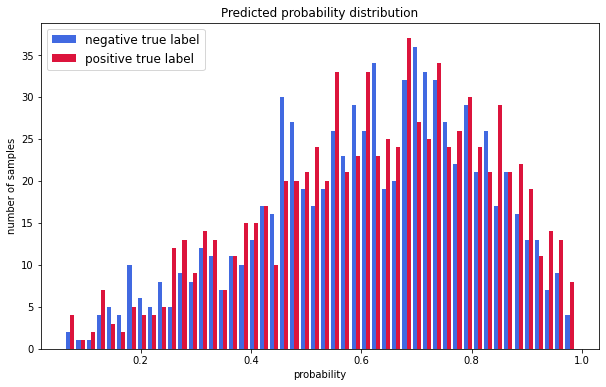

In [ ]:
plt.figure(figsize=(10, 6))
# plt.hist(cbr_pred_proba[:, 1], bins=30, color='royalblue', label='Word2Vec + catboost') 
plt.hist([lstm_pred_proba[y_val==0], lstm_pred_proba[y_val==1]], 
         color=['royalblue', 'crimson'], 
         label=['negative true label', 'positive true label'], bins=50)
plt.title('Predicted probability distribution')
plt.xlabel('probability')
plt.ylabel('number of samples')
plt.legend(prop={'size': 12})
plt.show()

In [ ]:
lstm_pred_proba = model.predict(X_train)
lstm_pred = np.where(lstm_pred_proba>0.5, 1, 0)
print('Train accuracy: {}'.format(accuracy_score(y_train, lstm_pred)))
print('Train precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_train, lstm_pred, average='binary')))
print('Train roc_auc_score: {}'.format(roc_auc_score(y_train, lstm_pred_proba)))
print(lstm_pred.sum() / X_train.shape[0])

Train accuracy: 0.9171694318753142
Train precision_recall_fscore_support: (0.9146092865232163, 0.9347222222222222, 0.9245563823697767, None)
Train roc_auc_score: 0.9534167392433688
0.5549270990447461


In [ ]:
lstm_pred_proba = model.predict(X_val)
lstm_pred = np.where(lstm_pred_proba>0.5, 1, 0) # lstm_pred_proba.mean()
print('Validation accuracy: {}'.format(accuracy_score(y_val, lstm_pred)))
print('Validation precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_val, lstm_pred, average='binary')))
print('Validation roc_auc_score: {}'.format(roc_auc_score(y_val, lstm_pred_proba)))
print(lstm_pred.sum() / X_val.shape[0])

Validation accuracy: 0.5027652086475616
Validation precision_recall_fscore_support: (0.507181328545781, 0.5621890547263682, 0.533270410571024, None)
Validation roc_auc_score: 0.4941168143024714
0.5600804424333836


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


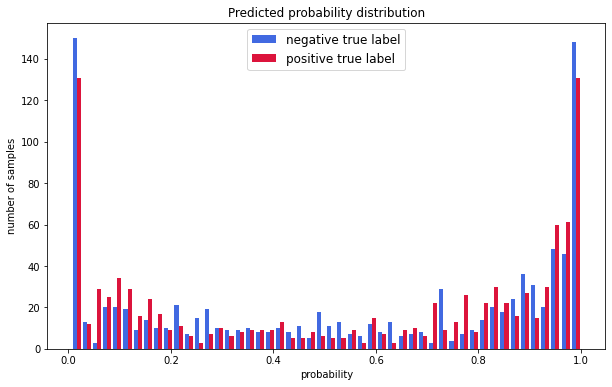

In [ ]:
plt.figure(figsize=(10, 6))
# plt.hist(cbr_pred_proba[:, 1], bins=30, color='royalblue', label='Word2Vec + catboost') 
plt.hist([lstm_pred_proba[y_val==0], lstm_pred_proba[y_val==1]], 
         color=['royalblue', 'crimson'], 
         label=['negative true label', 'positive true label'], bins=50)
plt.title('Predicted probability distribution')
plt.xlabel('probability')
plt.ylabel('number of samples')
plt.legend(prop={'size': 12})
plt.show()

In [ ]:
lstm_pred_proba = model.predict(X_val)
lstm_pred = np.where(lstm_pred_proba>0.5, 1, 0) # lstm_pred_proba.mean()
print('Validation accuracy: {}'.format(accuracy_score(y_val, lstm_pred)))
print('Validation precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_val, lstm_pred, average='binary')))
print('Validation roc_auc_score: {}'.format(roc_auc_score(y_val, lstm_pred_proba)))
print(lstm_pred.sum() / X_val.shape[0])

Validation accuracy: 0.8536953242835595
Validation precision_recall_fscore_support: (0.8455357142857143, 0.8892018779342723, 0.8668192219679633, None)
Validation roc_auc_score: 0.9354653171554581
0.563097033685269


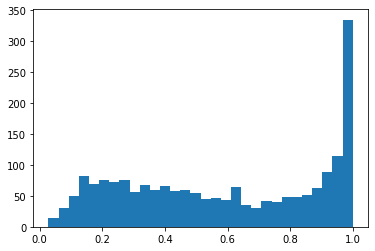

In [ ]:
plt.hist(lstm_pred_proba, bins=30)
plt.show()

In [ ]:
lstm_pred_proba = model.predict(X_val)
lstm_pred = np.where(lstm_pred_proba>0.5, 1, 0) # lstm_pred_proba.mean()
print('Validation accuracy: {}'.format(accuracy_score(y_val, lstm_pred)))
print('Validation precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_val, lstm_pred, average='binary')))
print('Validation roc_auc_score: {}'.format(roc_auc_score(y_val, lstm_pred_proba)))
print(lstm_pred.sum() / X_val.shape[0])

Validation accuracy: 0.7757667169431876
Validation precision_recall_fscore_support: (0.7811080835603996, 0.8075117370892019, 0.7940904893813481, None)
Validation roc_auc_score: 0.8340787147125176
0.5535444947209653


In [ ]:
lstm_pred_proba = model.predict(X_train)
lstm_pred = np.where(lstm_pred_proba>0.5, 1, 0)
print('Train accuracy: {}'.format(accuracy_score(y_train, lstm_pred)))
print('Train precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_train, lstm_pred, average='binary')))
print('Train roc_auc_score: {}'.format(roc_auc_score(y_train, lstm_pred_proba)))
print(lstm_pred.sum() / X_train.shape[0])

Train accuracy: 0.8044243338360986
Train precision_recall_fscore_support: (0.812962962962963, 0.8244131455399061, 0.8186480186480186, None)
Train roc_auc_score: 0.8494562704509888
0.5429864253393665


In [ ]:
lstm_pred_proba = model.predict(X_train)
lstm_pred = np.where(lstm_pred_proba>0.5, 1, 0)
print('Train accuracy: {}'.format(accuracy_score(y_train, lstm_pred)))
print('Train precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_train, lstm_pred, average='binary')))
print('Train roc_auc_score: {}'.format(roc_auc_score(y_train, lstm_pred_proba)))
print(lstm_pred.sum() / X_train.shape[0])

Train accuracy: 0.8809299403078856
Train precision_recall_fscore_support: (0.8911764705882353, 0.8864833235810415, 0.8888237019653858, None)
Train roc_auc_score: 0.9228287389056103
0.5340873389883758


In [ ]:
lstm_pred_proba = model.predict(X_val)
lstm_pred = np.where(lstm_pred_proba>0.5, 1, 0)
print('Validation accuracy: {}'.format(accuracy_score(y_val, lstm_pred)))
print('Validation precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_val, lstm_pred, average='binary')))
print('Validation roc_auc_score: {}'.format(roc_auc_score(y_val, lstm_pred_proba)))
print(lstm_pred.sum() / X_val.shape[0])

Validation accuracy: 0.5211267605633803
Validation precision_recall_fscore_support: (0.5191919191919192, 1.0, 0.6835106382978724, None)
Validation roc_auc_score: 0.5175097276264591
0.9959758551307847


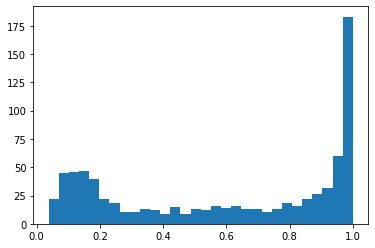

In [ ]:
plt.hist(lstm_pred_proba, bins=30)
plt.show()

(array([ 4., 11., 17., 12., 16., 16., 18.,  9., 27., 28., 32., 23., 18.,
        33., 32., 34., 42., 42., 40., 35., 31., 30., 33., 43., 34., 30.,
        24., 38., 23., 20.]),
 array([0.07199398, 0.10245827, 0.13292256, 0.16338684, 0.19385113,
        0.22431542, 0.2547797 , 0.285244  , 0.31570828, 0.34617257,
        0.37663686, 0.40710115, 0.43756545, 0.46802974, 0.49849403,
        0.5289583 , 0.5594226 , 0.5898869 , 0.6203512 , 0.6508155 ,
        0.6812798 , 0.711744  , 0.7422083 , 0.7726726 , 0.8031369 ,
        0.8336012 , 0.86406547, 0.89452976, 0.92499405, 0.95545834,
        0.98592263], dtype=float32),
 <a list of 30 Patch objects>)

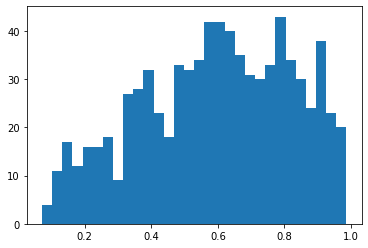

In [ ]:
plt.hist(lstm_pred_proba, bins=30)
plt.show()

In [ ]:
# for layer in model.layers:
#     weights = layer.get_weights() 

model.layers[6].get_weights()

IndexError: ignored

### finBERT

In [ ]:
# # ! pip install wrapt --upgrade --ignore-installed
# ! pip install finbert-embedding==0.1.4

In [ ]:
from finbert_embedding.embedding import FinbertEmbedding

text = "Spain spain portugal frog"

# Class Initialization (You can set default 'model_path=None' as your finetuned BERT model path while Initialization)
finbert = FinbertEmbedding()
word_embeddings = finbert.word_vector(text)
sentence_embedding = finbert.sentence_vector(text)

In [ ]:
from scipy.spatial.distance import cosine

1 - cosine(word_embeddings[0], word_embeddings[2])

0.7053200602531433

In [ ]:
train_transf, val_transf, y_train, y_val, vectorizer, comb_df = preprocessing_data(N_ARTICLES=25,
                                                                                   PREPROC='LEMM',
                                                                                   STOPWORDS=True,
                                                                                   TARGET_DAY='same',
                                                                                   NGRAM=(2,2), 
                                                                                   TFIDF_MAXFEAT=30000)

In [ ]:
# build vocab
spacy_nlp = spacy.load("en_core_web_sm")
textVectorizer = TextVectorization(max_tokens=30000)
text = pd.DataFrame(comb_df.headlines_stem)
textVectorizer.adapt(text.to_numpy())
vocab = textVectorizer.get_vocabulary()

headlines_emb = comb_df.headlines_stem.apply(lambda x: finbert.sentence_vector(x).numpy())
# headlines_emb = pd.DataFrame(np.vstack(headlines_emb))

RuntimeError: ignored

In [ ]:
val_thr = len(headlines_emb) - (len(headlines_emb) // 5)
X_train, X_val, y_train, y_val = headlines_emb[:val_thr], headlines_emb[val_thr:], comb_df.Label[:val_thr],

# model
from catboost import CatBoostClassifier

cbr = LogisticRegression(C=10, max_iter=1000) # C=10
cbr.fit(X_train, y_train)
# cbr = CatBoostClassifier(iterations=1000, max_depth=4) # ,learning_rate=1
# cbr.fit(X_train, y_train, silent=True)

cbr_pred = cbr.predict(X_val)
cbr_pred_proba = cbr.predict_proba(X_val)
print('Validation accuracy: {}'.format(accuracy_score(y_val, cbr_pred)))
print('Validation precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_val, cbr_pred, average='binary')))
print('Validation roc_auc_score: {}'.format(roc_auc_score(y_val, cbr_pred_proba[:, 1])))
print(cbr_pred.sum() / X_val.shape[0])

cbr_pred = cbr.predict(X_train)
cbr_pred_proba = cbr.predict_proba(X_train)
print('\nTrain accuracy: {}'.format(accuracy_score(y_train, cbr_pred)))
print('Train precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_train, cbr_pred, average='binary')))
print('Train roc_auc_score: {}'.format(roc_auc_score(y_train, cbr_pred_proba[:, 1])))

In [ ]:
### LSTM

In [ ]:
from keras import regularizers, optimizers
from keras.models import Sequential
from keras.layers import TextVectorization, Embedding, Dense, Input, LSTM, Lambda, Softmax, Dropout, GlobalMaxPool1D
from keras.initializers import Constant
from keras import backend
import tensorflow as tf
import spacy
import gensim.downloader as api
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from keras.layers import Conv2D, Conv1D

# try to tIMES 5 the dataset

# best baseline on gridsearch
train_transf, val_transf, y_train, y_val, vectorizer, comb_df = preprocessing_data(N_ARTICLES=25,
                                                                                   PREPROC='LEMM',
                                                                                   STOPWORDS=True,
                                                                                   TARGET_DAY='same',
                                                                                   NGRAM=(2,2), 
                                                                                   TFIDF_MAXFEAT=None)

## NEXT DAY TARGET
# comb_df = comb_df.sort_values('Date')
# comb_df['Label'] = list(comb_df['Label'])[1:] + [0]
## ###

# headline concatenation
for j in range(5):
  for i in range(j*5+1, j*5+5+1):
    if i%5 == 1:
        comb_df['headlines'+str(j)+'_concat'] = comb_df['Top'+str(i)].apply(CountVectorizer().build_tokenizer())
    else:
        comb_df['headlines'+str(j)+'_concat'] += comb_df['Top'+str(i)].apply(CountVectorizer().build_tokenizer())

# text preprocessing
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
nltk_stopwords_set = list(set(stopwords.words('english')))

for j in range(5):
  comb_df['headlines'+str(j)+'_stem'] = comb_df['headlines'+str(j)+'_concat'].apply(lambda sent: ' '.join([
    lemmatizer.lemmatize(w.lower()) for w in sent 
    if w.lower() not in nltk_stopwords_set 
    and w not in punctuation]))

comb_df = pd.concat([comb_df[['headlines0_stem', 'Label', 'Date']].rename(columns={"headlines0_stem": "headlines_stem"}),
                     comb_df[['headlines1_stem', 'Label', 'Date']].rename(columns={"headlines1_stem": "headlines_stem"}),
                     comb_df[['headlines2_stem', 'Label', 'Date']].rename(columns={"headlines2_stem": "headlines_stem"}),
                     comb_df[['headlines3_stem', 'Label', 'Date']].rename(columns={"headlines3_stem": "headlines_stem"}),
                     comb_df[['headlines4_stem', 'Label', 'Date']].rename(columns={"headlines4_stem": "headlines_stem"})]).reset_index(drop=True)

comb_df = comb_df.sort_values(by='Date', ascending=True).drop(columns=['Date']).reset_index(drop=True)

In [ ]:
train_transf, val_transf, y_train, y_val, vectorizer, comb_df = preprocessing_data(N_ARTICLES=25,
                                                                                   PREPROC='LEMM',
                                                                                   STOPWORDS=True,
                                                                                   TARGET_DAY='same',
                                                                                   NGRAM=(2,2), 
                                                                                   TFIDF_MAXFEAT=None)

In [ ]:
# linguistic model
# w2v = api.load('word2vec-google-news-300')
# w2v_sentences = comb_df.headlines_stem.apply(lambda x: x.split())
# w2v = Word2Vec(sentences=w2v_sentences, size=300, window=5, min_count=1, workers=4) # common_texts

# build vocab
spacy_nlp = spacy.load("en_core_web_sm")
textVectorizer = TextVectorization(max_tokens=30000) # 50000)
text = pd.DataFrame(comb_df.headlines_stem)
textVectorizer.adapt(text.to_numpy())
vocab = textVectorizer.get_vocabulary()

# embedding matrix
skip_vocab = list(map(str, vocab))
num_tokens = len(skip_vocab)
embedding_dim = len(finbert.word_vector('word')[0]) # len(spacy_nlp('word').vector) # len(w2v['word'])
embedding_matrix = np.zeros((num_tokens, embedding_dim))
null_check_cnt = 0
for i, word in enumerate(skip_vocab): 
  if i%3000==0: 
    print(i, word, end='; ')
  
  if word=='' or word=='[UNK]':
    null_check_cnt+=1
    embedding_matrix[i] = np.zeros(finbert.word_vector('word')[0].shape) # np.zeros(w2v.wv['word'].shape) # np.zeros(spacy_nlp('word').vector.shape) # np.zeros(w2v['word'].shape)
  else: 
    # if word in w2v.wv: # spacy_nlp.vocab: # w2v:
    embedding_matrix[i] = finbert.word_vector(word)[0].numpy()

Embedding_layer = Embedding(
    num_tokens, 
    embedding_dim, 
    embeddings_initializer=Constant(embedding_matrix), 
    trainable=False)

0 ; 3000 reaction; 6000 comeback; 9000 concentrate; 12000 slush; 15000 perilous; 18000 whining; 21000 rahman; 24000 kcna; 27000 decommunisation; 

In [ ]:
#  model
model = Sequential()
model.add(Input(shape=(1,), dtype=tf.string))
model.add(textVectorizer)
model.add(Embedding_layer)
model.add(LSTM(8, return_sequences=True))
# model.add(Conv1D(8, 3))
# model.add(Lambda(lambda x: backend.mean(x, axis=1)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # l1=1e-5, l2=1e-4
# model.add(Dense(4, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # l1=1e-5, l2=1e-4
model.add(Dense(1, activation='sigmoid')) # tf.keras.activations.softmax))

adam = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_func = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=adam, loss=loss_func, metrics=['accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_6 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 768)         23040000  
                                                                 
 lstm_5 (LSTM)               (None, None, 8)           24864     
                                                                 
 global_max_pooling1d_7 (Glo  (None, 8)                0         
 balMaxPooling1D)                                                
                                                                 
 dropout_7 (Dropout)         (None, 8)                 0         
                                                                 
 dense_16 (Dense)            (None, 8)                

In [ ]:
val_thr = len(comb_df) - (len(comb_df) // 6)
X_train, X_val, y_train, y_val = comb_df.headlines_stem[:val_thr], comb_df.headlines_stem[val_thr:], comb_df.Label[:val_thr], comb_df.Label[val_thr:]
X_train.shape, X_val.shape, y_train.shape, y_val.shape

model_history = model.fit(X_train, #.reset_index(), 
                          y_train, 
                          batch_size=16, 
                          epochs=20, # 30
                          validation_split=0.1)

Epoch 1/20
94/94 [==============================] - 36s 315ms/step - loss: 0.7040 - accuracy: 0.5194 - val_loss: 0.6936 - val_accuracy: 0.5301
Epoch 2/20
94/94 [==============================] - 16s 168ms/step - loss: 0.6934 - accuracy: 0.5369 - val_loss: 0.6931 - val_accuracy: 0.5301
Epoch 3/20
94/94 [==============================] - 15s 163ms/step - loss: 0.6918 - accuracy: 0.5416 - val_loss: 0.6922 - val_accuracy: 0.5301
Epoch 4/20
94/94 [==============================] - 16s 166ms/step - loss: 0.6906 - accuracy: 0.5416 - val_loss: 0.6941 - val_accuracy: 0.5301
Epoch 5/20
94/94 [==============================] - 16s 165ms/step - loss: 0.6915 - accuracy: 0.5315 - val_loss: 0.6921 - val_accuracy: 0.5301
Epoch 6/20
94/94 [==============================] - 15s 162ms/step - loss: 0.6921 - accuracy: 0.5302 - val_loss: 0.6918 - val_accuracy: 0.5301
Epoch 7/20
94/94 [==============================] - 17s 177ms/step - loss: 0.6902 - accuracy: 0.5261 - val_loss: 0.6935 - val_accuracy: 0.5301

In [ ]:
lstm_pred_proba = model.predict(X_train)
lstm_pred = np.where(lstm_pred_proba>0.5, 1, 0)
print('Train accuracy: {}'.format(accuracy_score(y_train, lstm_pred)))
print('Train precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_train, lstm_pred, average='binary')))
print('Train roc_auc_score: {}'.format(roc_auc_score(y_train, lstm_pred_proba)))
print(lstm_pred.sum() / X_train.shape[0])

lstm_pred_proba = model.predict(X_val)
lstm_pred = np.where(lstm_pred_proba>0.5, 1, 0) # lstm_pred_proba.mean()
print('Validation accuracy: {}'.format(accuracy_score(y_val, lstm_pred)))
print('Validation precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_val, lstm_pred, average='binary')))
print('Validation roc_auc_score: {}'.format(roc_auc_score(y_val, lstm_pred_proba)))
print(lstm_pred.sum() / X_val.shape[0])

Train accuracy: 0.5404101326899879
Train precision_recall_fscore_support: (0.5404101326899879, 1.0, 0.701644479248238, None)
Train roc_auc_score: 0.4918000972534683
1.0
Validation accuracy: 0.5105740181268882
Validation precision_recall_fscore_support: (0.5105740181268882, 1.0, 0.676, None)
Validation roc_auc_score: 0.47622178391409165
1.0


## hyperparameters

In [ ]:
N_ARTICLES = 25
PREPROC = 'LEMM' # None, 'STEM'

## subreddit parsing

In [ ]:
# from psaw import PushshiftAPI
# from datetime import timedelta 
# import datetime as dt
# import praw 
# import pandas as pd
# from tqdm import tqdm

# # use PRAW
# reddit_read_only = praw.Reddit(client_id="K5pT1cU3gcI1o-3sMNLitw",
#                                client_secret="0QgPtXnTaImRzVUaaBVO9AmwMEzSfQ",
#                                user_agent="daviddramb") 
# # to use PSAW
# api = PushshiftAPI()

# subreddit = 'worldnews' # reddit_read_only.subreddit("worldnews")
# posts_dict = {"Title": [],  "Score": [], "Post_dt": []} # "Total_Comments": [], "Post_dttm": []

# for day in range(1500):
#     ts_after = int((datetime(2000, 10, 1) + timedelta(day)).timestamp())
#     ts_before = int((datetime(2000, 10, 2) + timedelta(day)).timestamp())
#     gen = api.search_submissions(after=ts_after, before=ts_before, 
#                                  filter=['id'], subreddit=subreddit,
#                                  score = ">100", limit=25)
#     for submission_psaw in gen:
#         submission_id = submission_psaw.d_['id']
#         submission_praw = reddit_read_only.submission(id=submission_id)
        
#         posts_dict["Title"].append(submission_praw.title)
#         posts_dict["Score"].append(submission_praw.score)
#         # posts_dict['Post_dttm'].append(datetime.utcfromtimestamp(submission_praw.created_utc).strftime('%Y-%m-%d %H:%M:%S'))
#         posts_dict['Post_dt'].append(datetime.utcfromtimestamp(submission_praw.created_utc).date().strftime('%Y-%m-%d'))
    
#     print(day, end='; ')

# DIJA news kaggle

### news texts

In [ ]:
# https://www.kaggle.com/datasets/aaron7sun/stocknews?select=Combined_News_DJIA.csv
news = pd.read_csv('/content/drive/My Drive/thesis/Combined_News_DJIA.csv').fillna('')
print(news.shape)
print(min(news.Date), max(news.Date))
news.head(2)

(1989, 27)
2008-08-08 2016-07-01


,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."


In [ ]:
month_mapper = {1:'01. Jan', 2:'02. Feb', 3:'03. Mar', 4:'04. Apr', 5:'05. May', 6:'06. Jun', 
                7:'07. Jul', 8:'08. Aug', 9:'09. Sep', 10:'10. Oct', 11:'11. Nov', 12:'12. Dec'}

news['Datedate'] = pd.to_datetime(news.Date)
news['year'] = news.Date.apply(lambda x: str(x)[:4])
news['year_month'] = news.Date.apply(lambda x: str(x)[:7])
news['month'] = news.Date.apply(lambda x: str(x)[5:7])
news['quarter'] = news.Date.apply(lambda x: 'Q' + str((int(str(x)[5:7])-1) // 3 + 1))
news['year_quarter'] = news.Date.apply(lambda x: str(x)[:4] + '-Q' + str((int(str(x)[5:7])-1) // 3 + 1))
news['month_text'] = news.Date.apply(lambda x: month_mapper[int(str(x)[5:7])])

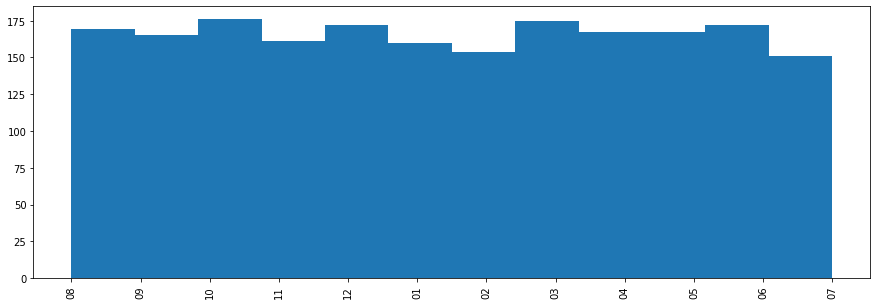

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(news.month, bins=12)
plt.xticks(rotation=90)
plt.show()

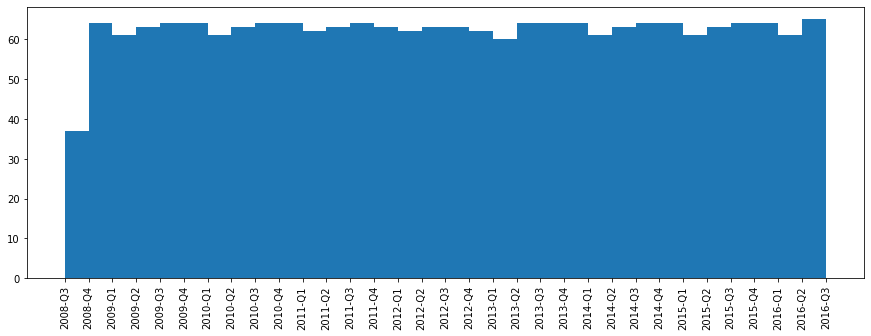

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(news.year_quarter, bins=8*4)
plt.xticks(rotation=90)
plt.show()

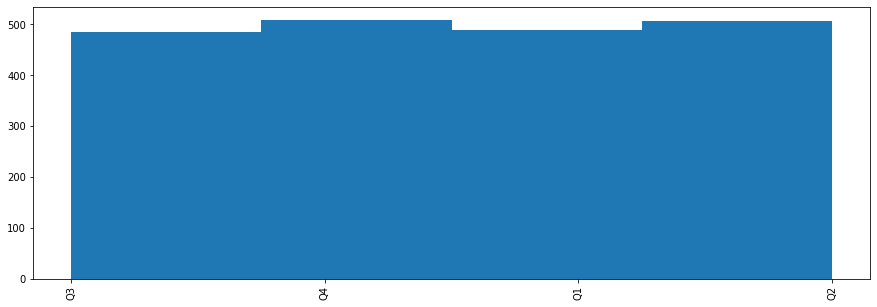

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(news.quarter, bins=4)
plt.xticks(rotation=90)
plt.show()

### preprocessing

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from pymystem3 import Mystem
from string import punctuation
from nltk.stem.snowball import SnowballStemmer
import spacy
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# takes time
for i in range(1, N_ARTICLES+1):
    if i == 1:
        news['headlines_concat'] = news['Top1'].apply(CountVectorizer().build_tokenizer())
    else:
        news['headlines_concat'] += news['Top'+str(i)].apply(CountVectorizer().build_tokenizer())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
###
news['headlines_stem'] = news['headlines_concat'].apply(lambda x: ' '.join(x))
###

In [ ]:
stemmer = SnowballStemmer('english')
spacy_nlp = spacy.load('en_core_web_sm')
nltk_stopwords_set = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def custom_stemmer(sent):
    return ' '.join([
                    #  stemmer.stem(w.lower()) for w in sent
                     lemmatizer.lemmatize(w.lower()) for w in sent 
                     if w.lower() not in nltk_stopwords_set # spacy_nlp.Defaults.stop_words
                     and w not in punctuation
                     ])

news['headlines_stem'] = news['headlines_concat'].apply(custom_stemmer)

In [ ]:
# sent = news['headlines_concat'][0]
# print(sent)
# print([stemmer.stem(w.lower()) for w in sent if w.lower() not in nltk_stopwords_set and w not in punctuation])
# print([lemmatizer.lemmatize(w.lower()) for w in sent if w.lower() not in nltk_stopwords_set and w not in punctuation])

In [ ]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer

# tok = Tokenizer(num_words=100000, oov_token='<UNK>')
# tok.fit_on_texts(news.headlines_concat)

# top_used_words = sorted(dict(tok.word_counts).items(), key=lambda x: x[1], reverse=True)[:30]

# plt.figure(figsize=(15, 5))
# plt.bar(list(zip(*top_used_words))[0], list(zip(*top_used_words))[1], color='royalblue')
# plt.title('Most used tokens: BEFORE PREPROCESSING')
# plt.xticks(rotation=90)
# plt.show()


# tok = Tokenizer(num_words=100000, oov_token='<UNK>')
# tok.fit_on_texts(news.headlines_stem)

# top_used_words = sorted(dict(tok.word_counts).items(), key=lambda x: x[1], reverse=True)[:30]

# plt.figure(figsize=(15, 5))
# plt.bar(list(zip(*top_used_words))[0], list(zip(*top_used_words))[1], color='royalblue')
# plt.title('Most used tokens: AFTER PREPROCESSING')
# plt.xticks(rotation=90)
# plt.show()

### negative words index

In [ ]:
! pip install pysentiment2

     |████████████████████████████████| 1.9 MB 7.4 MB/s 


In [ ]:
import pysentiment2 as ps
hiv4 = ps.HIV4()

def pos_neg_score(text):
  text_tokenized_hiv4 = hiv4.tokenize(text)
  pos = hiv4.get_score(text_tokenized_hiv4)['Positive']
  neg = hiv4.get_score(text_tokenized_hiv4)['Negative']
  len_sent = len(text.split(' '))

  return neg / len_sent


neg_score = news['headlines_stem'].apply(pos_neg_score)
news['neg_score'] = neg_score

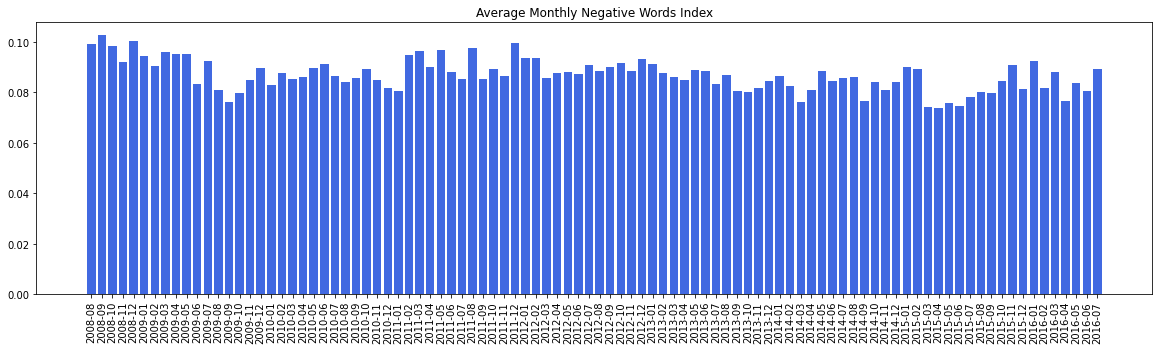

In [ ]:
neg_score_m = news.groupby(by='year_month').neg_score.mean()
Datedate_m = news.year_month.unique()

plt.figure(figsize=(20, 5))
plt.bar(Datedate_m, neg_score_m, color='royalblue')
plt.title('Average Monthly Negative Words Index')
plt.xticks(rotation=90)
plt.show()

### S&P500 index

In [ ]:
sp500 = pd.read_csv('/content/drive/My Drive/thesis/^spx_d-2008.csv')
print(sp500.shape)
print(min(sp500.Date), max(sp500.Date))
sp500.head()

(2861, 6)
2008-10-02 2020-02-13


,Date,Open,High,Low,Close,Volume
0,2008-10-02,1161.06,1161.06,1111.43,1114.28,3492022222
1,2008-10-03,1114.28,1153.82,1098.14,1099.23,3731177778
2,2008-10-06,1099.23,1099.23,1007.97,1056.89,4420011111
3,2008-10-07,1056.89,1072.91,996.23,996.23,3927338889
4,2008-10-08,996.23,1021.06,970.97,984.94,4842405556


In [ ]:
# добавим дату в формате даты 
sp500['dt'] = sp500['Date'].astype('datetime64[ns]')
print(min(sp500['dt']), max(sp500['dt']))

# остортируем по дате и пронумеруем строки 
sp500 = sp500.sort_values(by='dt')
sp500['idx'] = np.arange(len(sp500)) 

# таргет: строго больше (если равно, считаем, что из-за комиссии в убытке, в остальном, комиссией пренебрегаем)
sp500['target'] = np.where(sp500['Close'] > sp500['Open'], 1, 0) 

# добавим разницу между открытием и закрытием и размер свечи
sp500['chnge'] = sp500['Close'] - sp500['Open']
sp500['candle_h'] = sp500['High'] - sp500['Low']

2008-10-02 00:00:00 2020-02-13 00:00:00


In [ ]:
# немного эквилибристики: соберем датасет (дата-таргет)-данные_за_прошлый_день 
prev_day_stat = sp500.copy()
prev_day_stat['next_idx'] = prev_day_stat['idx'] + 1 
sp500_enrich = sp500.merge(prev_day_stat, how='inner', left_on='idx', right_on='next_idx', suffixes=('', '_prev')
                           )[['idx','Date','target','Date_prev','Open_prev','High_prev','Low_prev','Close_prev',
                              'Volume_prev','chnge_prev', 'candle_h_prev']]

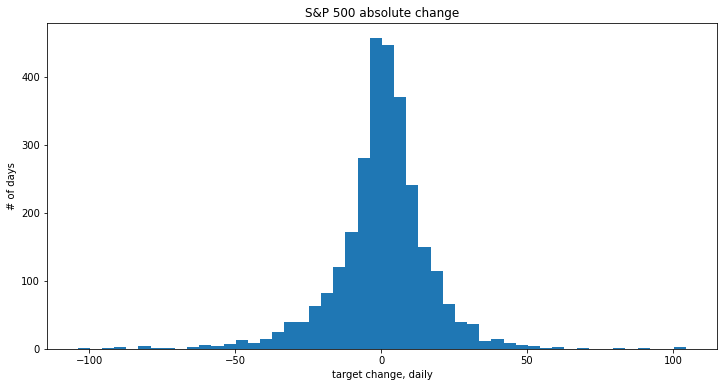

In [ ]:
fig, ax = plt.subplots()
ax.hist(sp500_enrich['chnge_prev'], bins=50)

fig.set_figwidth(12) 
fig.set_figheight(6)
ax.set_title('S&P 500 absolute change')
ax.set_xlabel('target change, daily') 
ax.set_ylabel('# of days') 

plt.show()

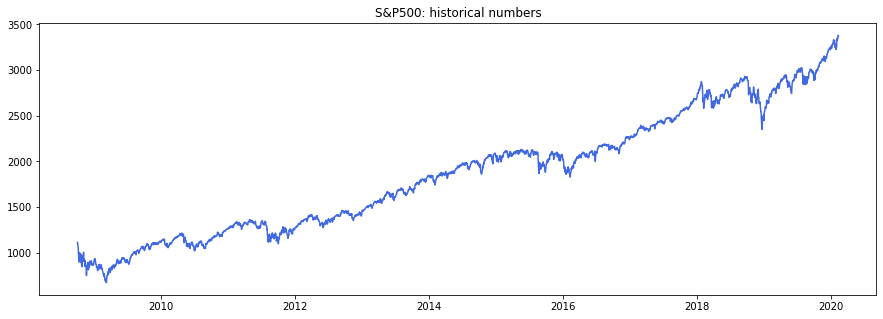

In [ ]:
plt.figure(figsize=(15, 5))
sp500.Datedate = pd.to_datetime(sp500.Date)
plt.plot(sp500.Datedate, sp500.Close, c='royalblue')
plt.title('S&P500: historical numbers')
plt.show()

### text - index connection

In [ ]:
# OR left_on='Date_prev'
df = sp500_enrich.merge(news[['Date','headlines_stem', 'Label']], how='inner', left_on='Date', right_on='Date')
# df = sp500_enrich.merge(news[['Date','headlines_stem']], how='inner', left_on='Date_prev', right_on='Date')
print(df.shape)

(1950, 13)


In [ ]:
# target day features
import datetime

df['weekday'] = df['Date'].apply(lambda dt: datetime.datetime.strptime(dt, '%Y-%m-%d').weekday()).astype(object)
df['year'] = df.Date.apply(lambda x: str(x)[:4])
df['month'] = df.Date.apply(lambda x: str(x)[5:7])
df['quarter'] = df.Date.apply(lambda x: 'Q' + str((int(str(x)[5:7])-1) // 3 + 1))
df.head(3)

,idx,Date,target,Date_prev,Open_prev,High_prev,Low_prev,Close_prev,Volume_prev,chnge_prev,candle_h_prev,headlines_stem,Label,weekday,year,month,quarter
0,1,2008-10-03,0,2008-10-02,1161.06,1161.06,1111.43,1114.28,3492022222,-46.78,49.63,strike kill 20 pakistan script written bbc gov...,0,4,2008,10,Q4
1,2,2008-10-06,0,2008-10-03,1114.28,1153.82,1098.14,1099.23,3731177778,-15.05,55.68,iceland sept 08 un best countri live 07 oct 08...,0,0,2008,10,Q4
2,3,2008-10-07,0,2008-10-06,1099.23,1099.23,1007.97,1056.89,4420011111,-42.34,91.26,russia won buy version war georgia fine won bu...,0,1,2008,10,Q4


In [ ]:
# S&P500 target vs DJIA target
(df['target'] == df['Label']).sum() / len(df['target']), np.corrcoef([df['target'], df['Label']])[0,1]

(0.8912820512820513, 0.7813031191368369)

### DJIA visual

In [ ]:
dji = pd.read_csv('/content/drive/My Drive/thesis/^dji_d.csv').sort_values(by='Date')
dji['Datedate'] = pd.to_datetime(dji.Date)
dji['Close_trailing5'] = dji['Close'].rolling(min_periods=1, window=5).mean()
dji['Close_trailing30'] = dji['Close'].rolling(min_periods=1, window=30).mean()
dji['Volume_trailing5'] = dji['Volume'].rolling(min_periods=1, window=5).mean()
dji['Volume_trailing30'] = dji['Volume'].rolling(min_periods=1, window=30).mean()
dji['Close_maxmin5'] = dji['Close'].rolling(min_periods=1, window=5).max() / dji['Close'].rolling(min_periods=1, window=5).min()
dji['Close_maxmin30'] = dji['Close'].rolling(min_periods=1, window=5).max() / dji['Close'].rolling(min_periods=1, window=5).min()
dji['Close_rate2'] = dji['Close'] / dji['Close'].rolling(min_periods=1, window=2).agg(lambda rows: np.array(rows)[0])
dji['Close_rate5'] = dji['Close'] / dji['Close'].rolling(min_periods=1, window=5).agg(lambda rows: np.array(rows)[0])
dji['Close_rate30'] = dji['Close'] / dji['Close'].rolling(min_periods=1, window=30).agg(lambda rows: np.array(rows)[0])
print(dji.shape)
dji.head(5)

(5603, 16)


,Date,Open,High,Low,Close,Volume,Datedate,Close_trailing5,Close_trailing30,Volume_trailing5,Volume_trailing30,Close_maxmin5,Close_maxmin30,Close_rate2,Close_rate5,Close_rate30
0,2000-01-03,11501.8,11522.0,11305.7,11357.5,169680388,2000-01-03,11357.500000,11357.500000,1.696804e+08,1.696804e+08,1.000000,1.000000,1.000000,1.000000,1.000000
1,2000-01-04,11349.8,11350.1,10986.5,10997.9,178357418,2000-01-04,11177.700000,11177.700000,1.740189e+08,1.740189e+08,1.032697,1.032697,0.968338,0.968338,0.968338
2,2000-01-05,10989.4,11215.1,10938.7,11122.7,203266571,2000-01-05,11159.366667,11159.366667,1.837681e+08,1.837681e+08,1.032697,1.032697,1.011348,0.979326,0.979326
3,2000-01-06,11113.4,11313.5,11098.5,11253.3,176642517,2000-01-06,11182.850000,11182.850000,1.819867e+08,1.819867e+08,1.032697,1.032697,1.011742,0.990825,0.990825
4,2000-01-07,11247.1,11528.1,11239.9,11522.6,184926808,2000-01-07,11250.800000,11250.800000,1.825747e+08,1.825747e+08,1.047709,1.047709,1.023931,1.014537,1.014537


In [ ]:
train_transf, val_transf, y_train, y_val, vectorizer, comb_df = preprocessing_data(N_ARTICLES=25,
                                                                                   PREPROC='LEMM', # None,
                                                                                   STOPWORDS=True,
                                                                                   TARGET_DAY='same',
                                                                                   NGRAM=(2,2), 
                                                                                   TFIDF_MAXFEAT=None)
comb_df['Candle_height'] = comb_df.High - comb_df.Low

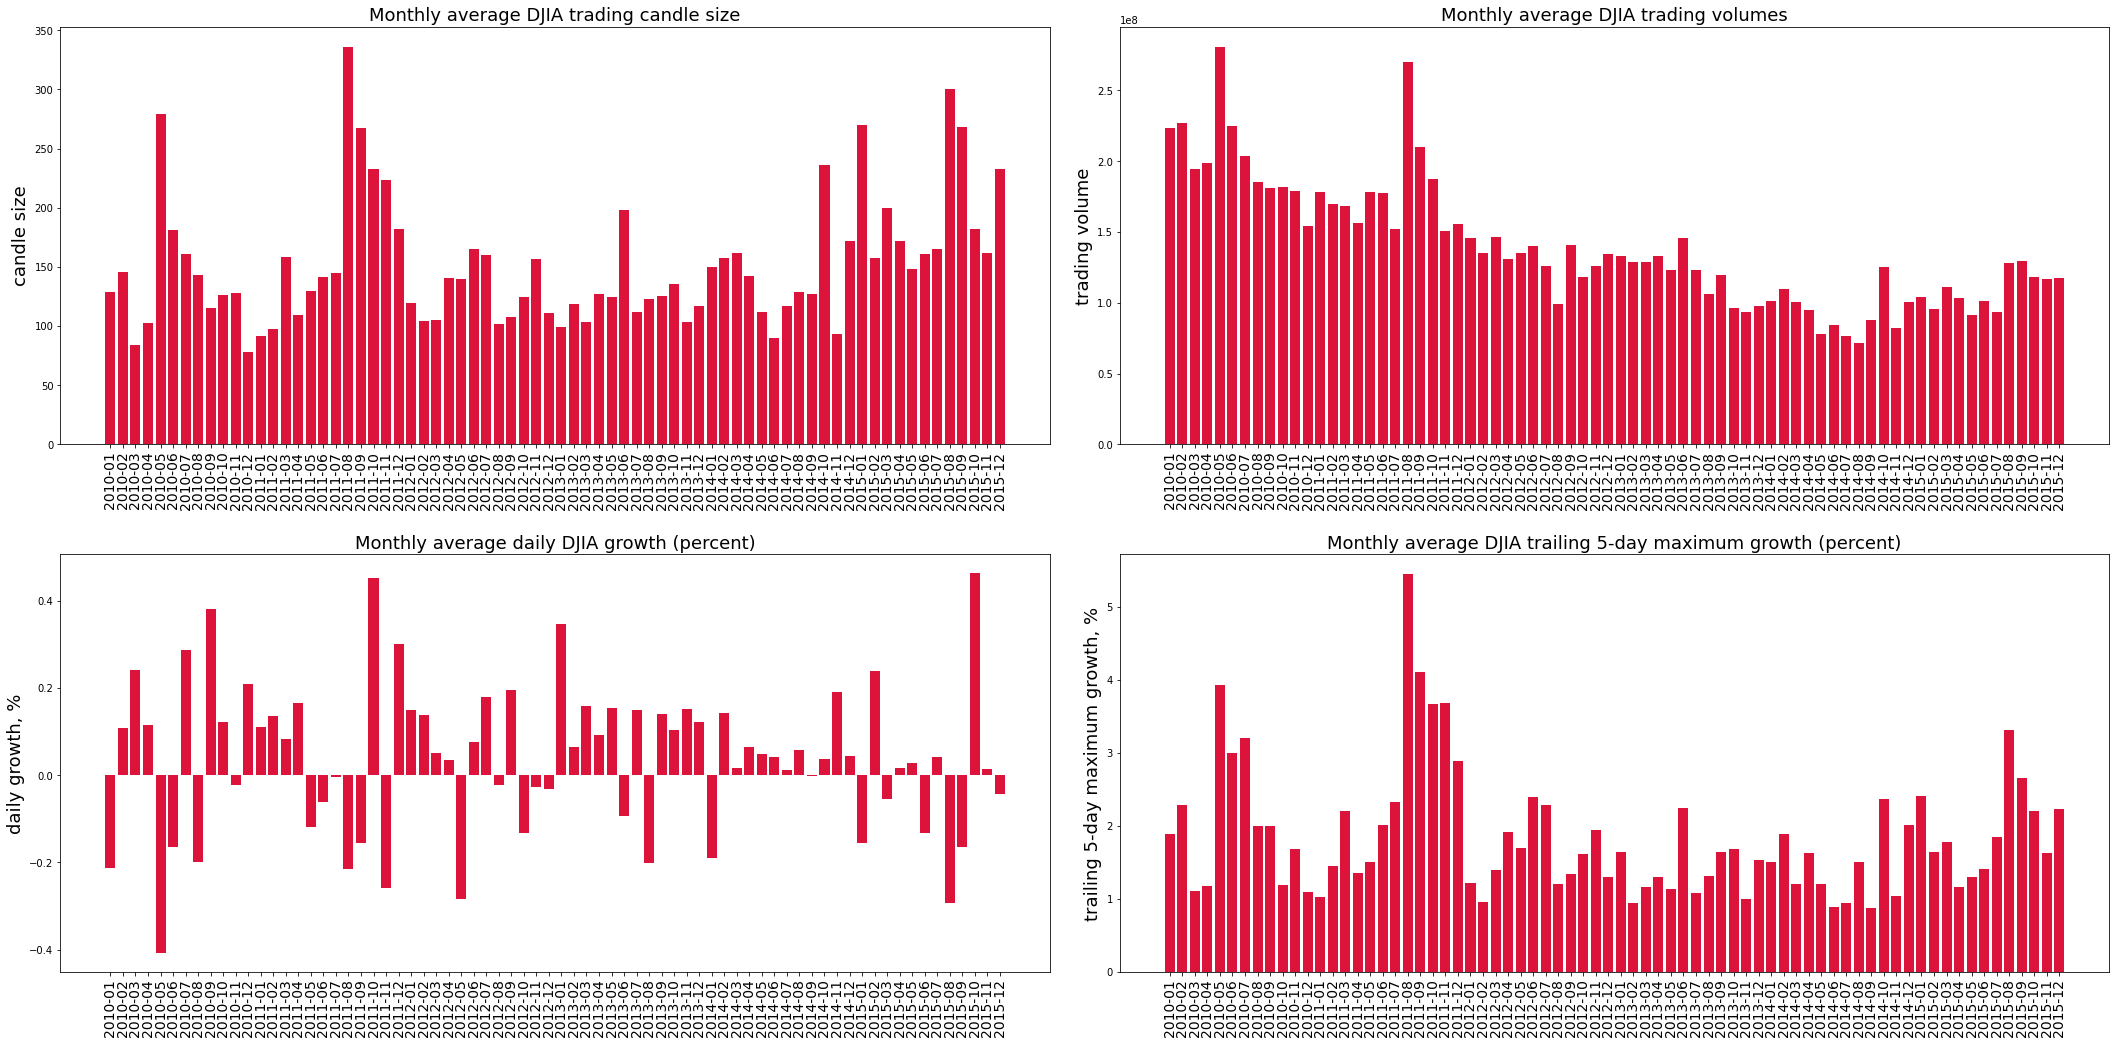

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(30,15))
comb_df_plot = comb_df[(comb_df.Datedate>='2010-01-01')&(comb_df.Datedate<'2016-01-01')]

fig.tight_layout(pad=2.)
ax[0, 0].bar(comb_df_plot.groupby('year_month').mean().Candle_height.index, comb_df_plot.groupby('year_month').mean().Candle_height.values, color='crimson')
ax[0, 0].set_title('Monthly average DJIA trading candle size', size=18)
ax[0, 0].set_ylabel('candle size', size=18)
ax[0, 0].tick_params(labelrotation=90, axis='x', labelsize=14)

fig.tight_layout(pad=2.5)
ax[0, 1].bar(comb_df_plot.groupby('year_month').mean().Volume.index, comb_df_plot.groupby('year_month').mean().Volume.values, color='crimson')
ax[0, 1].set_title('Monthly average DJIA trading volumes', size=18)
ax[0, 1].set_ylabel('trading volume', size=18)
ax[0, 1].tick_params(labelrotation=90, axis='x', labelsize=14)

fig.tight_layout(pad=2.5)
ax[1, 0].bar(comb_df_plot.groupby('year_month').mean().Close_rate2_perc.index, comb_df_plot.groupby('year_month').mean().Close_rate2_perc.values, color='crimson')
ax[1, 0].set_title('Monthly average daily DJIA growth (percent)', size=18)
ax[1, 0].set_ylabel('daily growth, %', size=18)
ax[1, 0].tick_params(labelrotation=90, axis='x', labelsize=14)

fig.tight_layout(pad=2.5)
ax[1, 1].bar(comb_df_plot.groupby('year_month').mean().Close_maxmin5_perc.index, comb_df_plot.groupby('year_month').mean().Close_maxmin5_perc.values, color='crimson')
ax[1, 1].set_title('Monthly average DJIA trailing 5-day maximum growth (percent)', size=18)
ax[1, 1].set_ylabel('trailing 5-day maximum growth, %', size=18)
ax[1, 1].tick_params(labelrotation=90, axis='x', labelsize=14)

del comb_df_plot
plt.show()

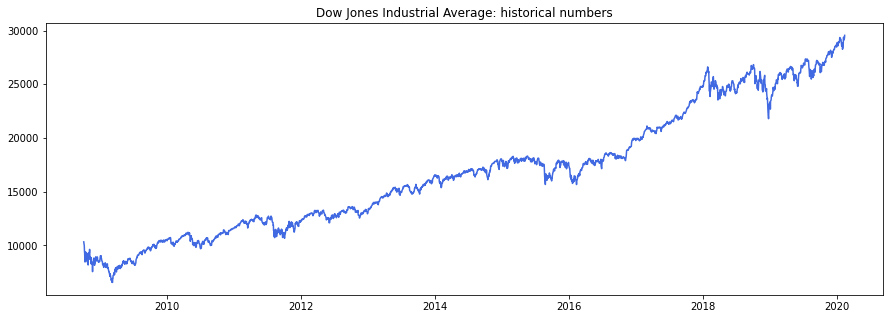

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(dji.Datedate[(dji.Datedate > '2008-10-02')&(dji.Datedate < '2020-02-13')], 
         dji.Close[(dji.Datedate > '2008-10-02')&(dji.Datedate < '2020-02-13')], c='royalblue')
plt.title('Dow Jones Industrial Average: historical numbers')
plt.show()

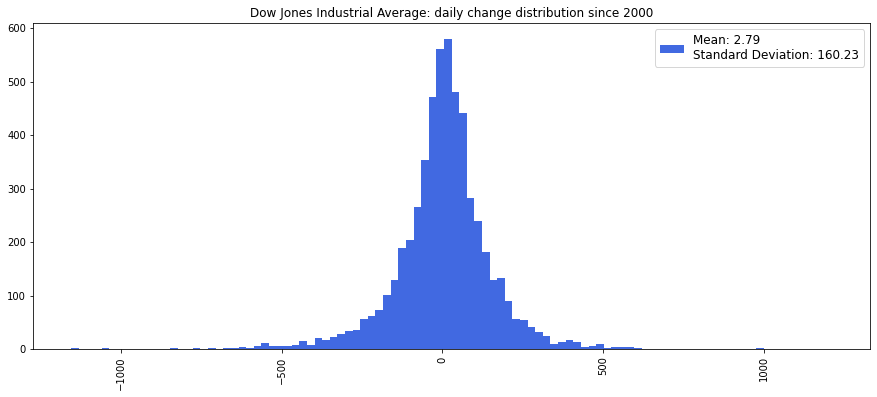

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


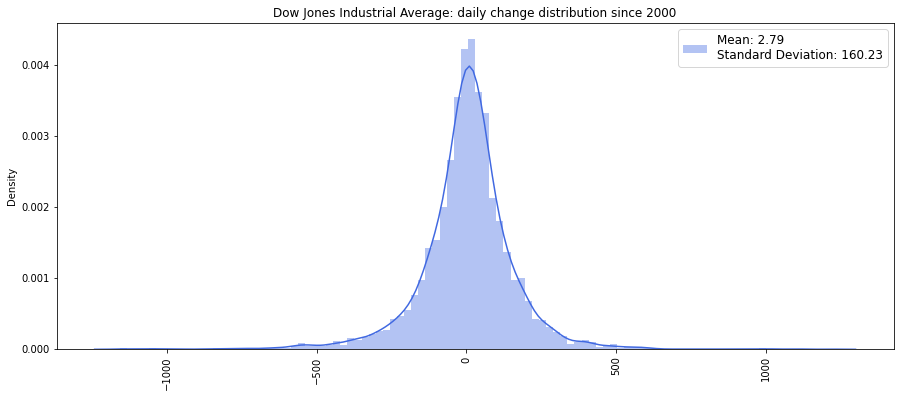

In [ ]:
plt.figure(figsize=(15, 6))
plt.hist(dji.Close-dji.Open, bins=100, color='royalblue', # darkturquoise
         label='Mean: {} \nStandard Deviation: {}'.format(round((dji.Close-dji.Open).mean(), 2), 
                                                 round((dji.Close-dji.Open).std(), 2))) 
plt.title('Dow Jones Industrial Average: daily change distribution since 2000')
plt.xticks(rotation=90)
plt.legend(prop={'size': 12})
plt.show()

import seaborn as sns
plt.figure(figsize=(15, 6))
sns.distplot(dji.Close-dji.Open, bins=100, color='royalblue', # darkturquoise
         label='Mean: {} \nStandard Deviation: {}'.format(round((dji.Close-dji.Open).mean(), 2), 
                                                 round((dji.Close-dji.Open).std(), 2))) 
plt.title('Dow Jones Industrial Average: daily change distribution since 2000')
plt.xticks(rotation=90)
plt.legend(prop={'size': 12})
plt.show()

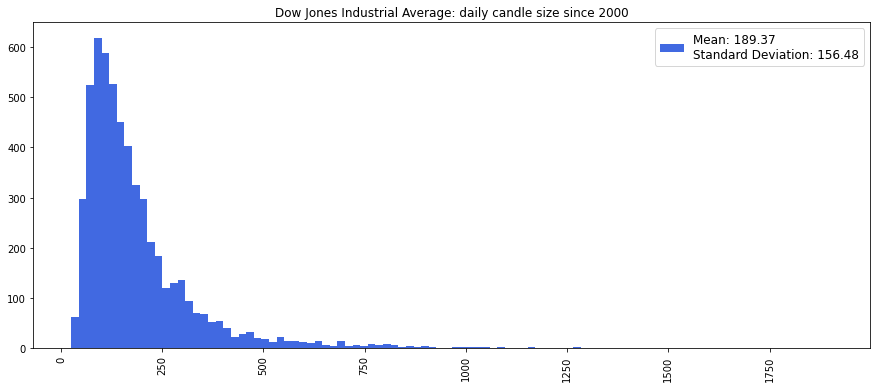

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


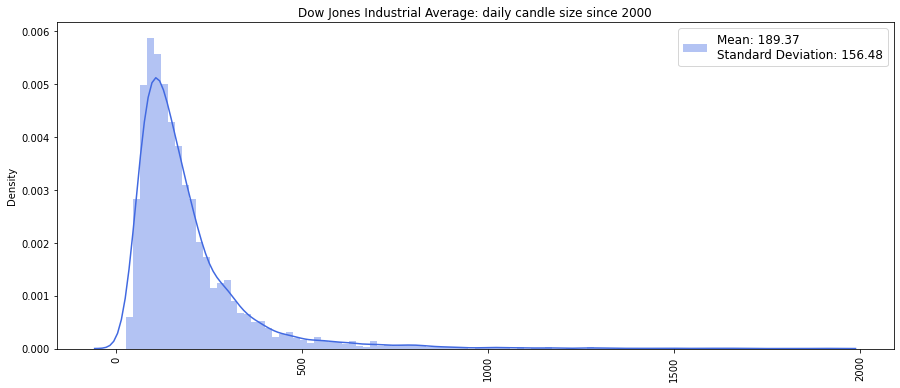

In [ ]:
plt.figure(figsize=(15, 6))
plt.hist(dji.High-dji.Low, bins=100, color='royalblue', 
         label='Mean: {} \nStandard Deviation: {}'.format(round((dji.High-dji.Low).mean(), 2), 
                                                 round((dji.High-dji.Low).std(), 2)))
plt.title('Dow Jones Industrial Average: daily candle size since 2000')
plt.xticks(rotation=90)
plt.legend(prop={'size': 12})
plt.show()

plt.figure(figsize=(15, 6))
sns.distplot(dji.High-dji.Low, bins=100, color='royalblue', 
         label='Mean: {} \nStandard Deviation: {}'.format(round((dji.High-dji.Low).mean(), 2), 
                                                 round((dji.High-dji.Low).std(), 2)))
plt.title('Dow Jones Industrial Average: daily candle size since 2000')
plt.xticks(rotation=90)
plt.legend(prop={'size': 12})
plt.show()

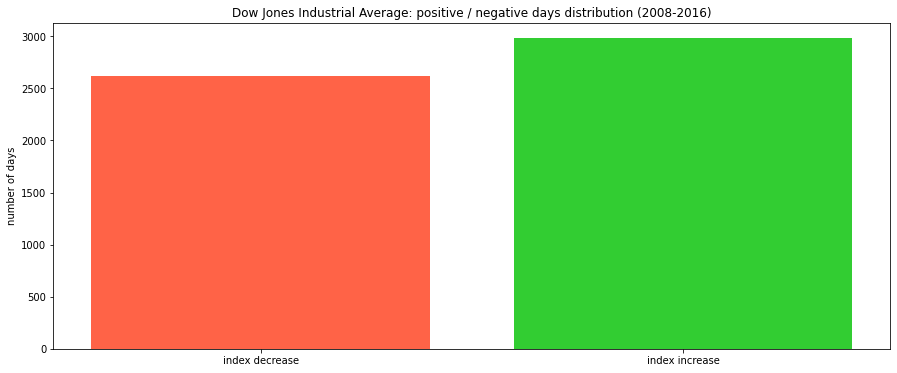

In [ ]:
plt.figure(figsize=(15, 6))
plt.bar('index decrease', (dji.Close-dji.Open<=0).sum(), color='tomato')
plt.bar('index increase', (dji.Close-dji.Open>0).sum(), color='limegreen')
plt.title('Dow Jones Industrial Average: positive / negative days distribution (2008-2016)')
plt.ylabel('number of days')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


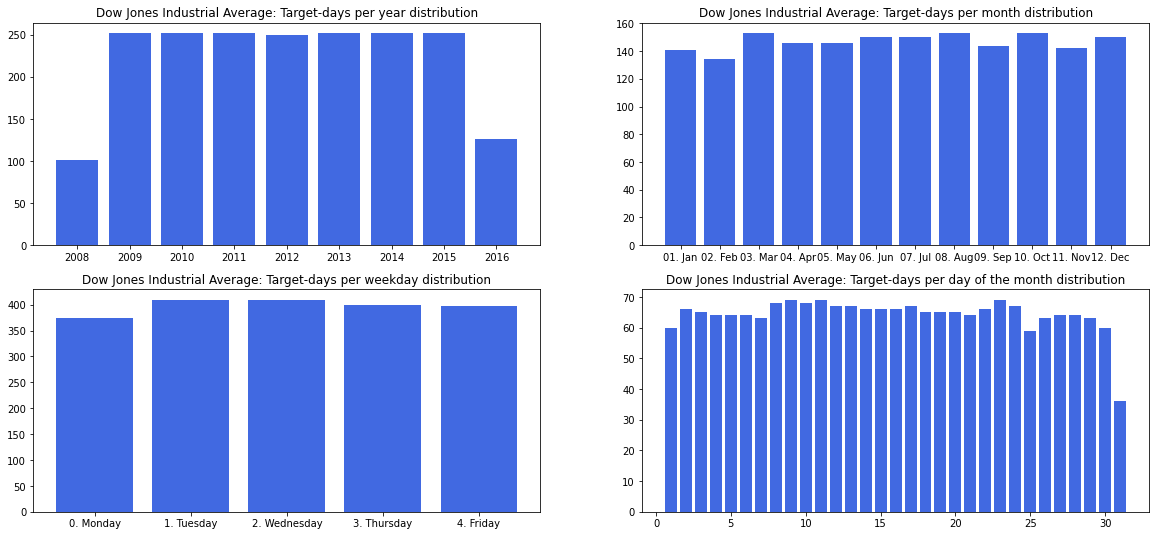

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(20, 9))

mnths = news.sort_values('month_text')[(news['Date']>'2009-01-01')&(news['Date']<'2016-01-01')]
mnths['ones'] = 1
years = news.sort_values('year')
years['ones'] = 1
wkdays_mapper = {0: '0. Monday', 1: '1. Tuesday', 2: '2. Wednesday', 3: '3. Thursday', 
                 4: '4. Friday', 5: '5. Saturday', 6: '6. Sunday'}
wkdays = pd.DataFrame(pd.to_datetime(news.Date).apply(lambda x: wkdays_mapper[x.weekday()]))
wkdays['ones'] = 1
dys = pd.DataFrame(news.Date.apply(lambda x: int(x[8:10])))
dys['ones'] = 1


ax[0,0].bar(years.groupby('year').count().index, years.groupby('year').count().ones, color='royalblue')
ax[0,0].set_title('Dow Jones Industrial Average: Target-days per year distribution')

ax[0,1].bar(mnths.groupby('month_text').count().index, mnths.groupby('month_text').count().ones, color='royalblue')
ax[0,1].set_title('Dow Jones Industrial Average: Target-days per month distribution')

ax[1,0].bar(wkdays.groupby('Date').count().index, wkdays.groupby('Date').count().ones, color='royalblue')
ax[1,0].set_title('Dow Jones Industrial Average: Target-days per weekday distribution')

ax[1,1].bar(dys.groupby('Date').count().index, dys.groupby('Date').count().ones, color='royalblue')
ax[1,1].set_title('Dow Jones Industrial Average: Target-days per day of the month distribution')

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


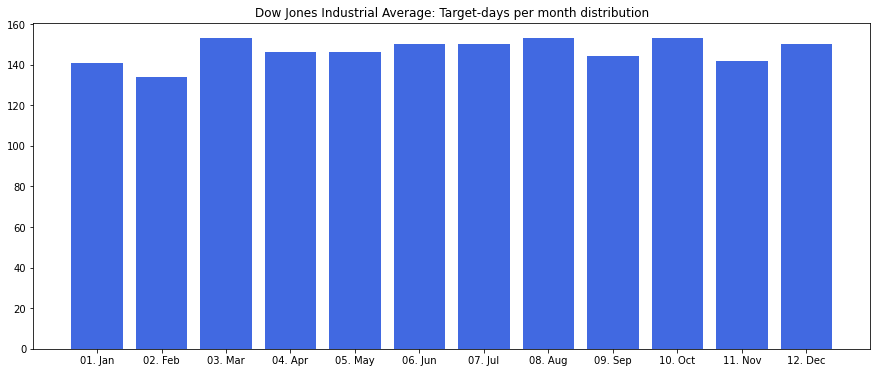

In [ ]:
mnths = news.sort_values('month_text')[(news['Date']>'2009-01-01')&(news['Date']<'2016-01-01')]
mnths['ones'] = 1

plt.figure(figsize=(15, 6))
# plt.hist(news.sort_values('month_text')['month_text'], bins=12, color='royalblue')
plt.bar(mnths.groupby('month_text').count().index, mnths.groupby('month_text').count().ones, color='royalblue')
plt.title('Dow Jones Industrial Average: Target-days per month distribution')
plt.show()

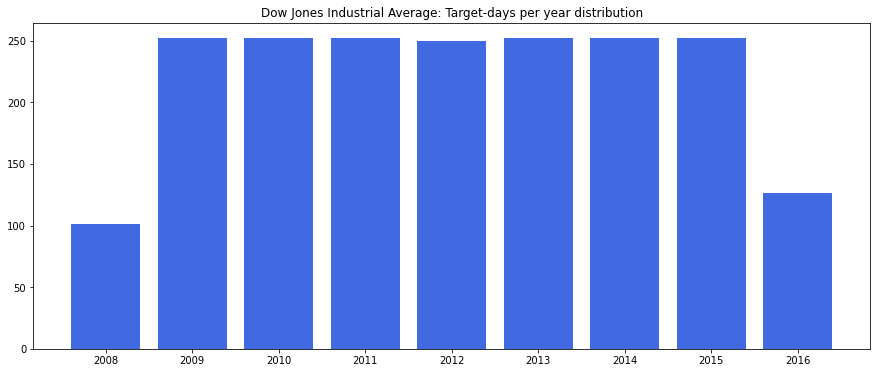

In [ ]:
years = news.sort_values('year')
years['ones'] = 1

plt.figure(figsize=(15, 6))
# plt.hist(news.sort_values('year')['year'], bins=9, color='royalblue')
plt.bar(years.groupby('year').count().index, years.groupby('year').count().ones, color='royalblue')
plt.title('Dow Jones Industrial Average: Target-days per year distribution')
plt.show()

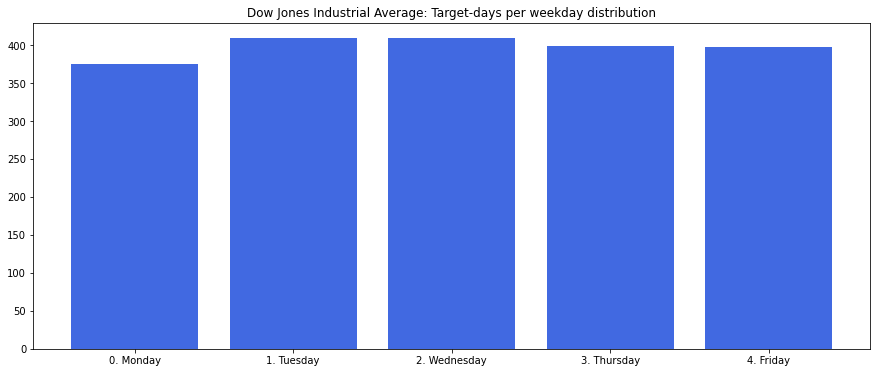

In [ ]:
wkdays_mapper = {0: '0. Monday', 1: '1. Tuesday', 2: '2. Wednesday', 3: '3. Thursday', 
                 4: '4. Friday', 5: '5. Saturday', 6: '6. Sunday'}
wkdays = pd.DataFrame(pd.to_datetime(news.Date).apply(lambda x: wkdays_mapper[x.weekday()]))
wkdays['ones'] = 1

plt.figure(figsize=(15, 6))
plt.bar(wkdays.groupby('Date').count().index, wkdays.groupby('Date').count().ones, color='royalblue')
plt.title('Dow Jones Industrial Average: Target-days per weekday distribution')
plt.show()

### baseline

In [ ]:
# abab = df[['headlines_stem', 'Label']][1:].append(pd.DataFrame([['aaa', 0]], columns=['headlines_stem', 'Label']))

In [ ]:
# connect news w previous day market info
dji['Datedate_next'] = list(dji.Datedate)[1:] + [list(dji.Datedate)[-1]+pd.DateOffset(1)]
comb_df = news.merge(dji, left_on='Datedate', right_on='Datedate_next', how='left', suffixes=('', '_dji'))
print(news.shape, comb_df.shape)

### DJIA target
df = comb_df.sort_values('Date')[['headlines_stem', 'Label']].copy()
df['target'] = df['Label']

# next day target
# df['target'] = list(df['Label'])[1:] + [0]
###

(1989, 36) (1989, 44)


In [ ]:
# https://www.kaggle.com/code/ndrewgele/omg-nlp-with-the-djia-and-reddit
# NO TEXT PREPROCESSING (just concat 25)
vectorizer = CountVectorizer() # CountVectorizer(ngram_range=(2,2))
vectorizer = TfidfVectorizer(ngram_range=(2,2)) # TfidfVectorizer(ngram_range=(2,2))

val_thr = len(df) - (len(df) // 4)
X_train, X_val, y_train, y_val = df.headlines_stem[:val_thr], df.headlines_stem[val_thr:], df.target[:val_thr], df.target[val_thr:]
# X_train, X_val, y_train, y_val = df.headlines_stem[:val_thr], df.headlines_stem[val_thr:], df.Label[:val_thr], df.Label[val_thr:]

train_transf = vectorizer.fit_transform(X_train)
val_transf = vectorizer.transform(X_val)

In [ ]:
# # join embeddings and financial data
# new_cols = vectorizer.get_feature_names()

# ### Train
# fin_emb_train = comb_df[['Open','High','Low','Close','Volume']][:val_thr]
# fin_emb_train['neg_score'] = np.array(comb_df['headlines_stem'].apply(pos_neg_score))[:val_thr]
# # fin_emb_train = fin_emb_train.join(pd.DataFrame(train_transf.toarray(), columns=new_cols))
# fin_emb_train = fin_emb_train.join(pd.DataFrame.sparse.from_spmatrix(train_transf))

# ### Val
# fin_emb_val = comb_df[['Open','High','Low','Close','Volume']][val_thr:]
# fin_emb_val['neg_score'] = np.array(comb_df['headlines_stem'].apply(pos_neg_score))[val_thr:]
# # fin_emb_val = fin_emb_val.join(pd.DataFrame(val_transf.toarray(), columns=new_cols))
# fin_emb_val = fin_emb_val.join(pd.DataFrame.sparse.from_spmatrix(val_transf))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# # from catboost import CatBoostClassifier
# from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support
# from sklearn.linear_model import LogisticRegression

# # cbr = CatBoostClassifier(iterations=500,max_depth=4) # ,learning_rate=1
# # cbr.fit(X_train, y_train, silent=True)
# cbr = LogisticRegression()
# cbr.fit(fin_emb_train, y_train)

# # eval
# cbr_pred = cbr.predict(fin_emb_val)
# cbr_pred_proba = cbr.predict_proba(fin_emb_val)
# print('accuracy: {}'.format(accuracy_score(y_val, cbr_pred)))
# print('precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_val, cbr_pred, average='binary')))
# print('roc_auc_score: {}'.format(roc_auc_score(y_val, cbr_pred_proba[:, 1])))

# # train
# cbr_pred = cbr.predict(fin_emb_train)
# cbr_pred_proba = cbr.predict_proba(fin_emb_train)
# print('accuracy: {}'.format(accuracy_score(y_train, cbr_pred)))
# print('precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_train, cbr_pred, average='binary')))
# print('roc_auc_score: {}'.format(roc_auc_score(y_train, cbr_pred_proba[:, 1])))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


### PCA

In [ ]:
train_transf.shape

(1492, 330726)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

pca = PCA(n_components=2)
train_pc = pca.fit_transform(train_transf.toarray())
# val_pc = pca.transform(val_transf)

# svd = TruncatedSVD(n_components=1000, n_iter=7, random_state=42)
# svd.fit(train_transf)
# sorted(svd.explained_variance_ratio_)

principalDf = pd.DataFrame(data=train_pc, columns = ['pc 1', 'pc 2'])

In [ ]:
svd.explained_variance_ratio_.sum()

In [ ]:
print(12)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression

# cbr = CatBoostClassifier(iterations=100,max_depth=4) # ,learning_rate=1
# cbr.fit(advancedtrain, y_train, silent=True)
cbr = LogisticRegression()
cbr.fit(train_transf, y_train)

# eval
cbr_pred = cbr.predict(val_transf)
cbr_pred_proba = cbr.predict_proba(val_transf)
print('accuracy: {}'.format(accuracy_score(y_val, cbr_pred)))
print('precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_val, cbr_pred, average='binary')))
print('roc_auc_score: {}'.format(roc_auc_score(y_val, cbr_pred_proba[:, 1])))

accuracy: 0.5171026156941649
precision_recall_fscore_support: (0.5171026156941649, 1.0, 0.6816976127320954, None)
roc_auc_score: 0.5477464332036317


In [ ]:
# train
cbr_pred = cbr.predict(train_transf)
cbr_pred_proba = cbr.predict_proba(train_transf)
print('accuracy: {}'.format(accuracy_score(y_train, cbr_pred)))
print('precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_train, cbr_pred, average='binary')))
print('roc_auc_score: {}'.format(roc_auc_score(y_train, cbr_pred_proba[:, 1])))

accuracy: 1.0
precision_recall_fscore_support: (1.0, 1.0, 1.0, None)
roc_auc_score: 1.0


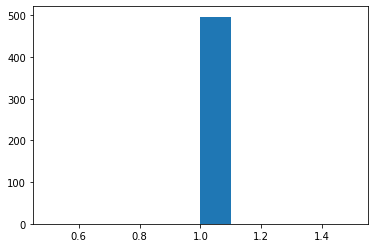

In [ ]:
# plt.hist(cbr_pred_proba[:, 1], bins=30)
plt.hist(cbr_pred)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


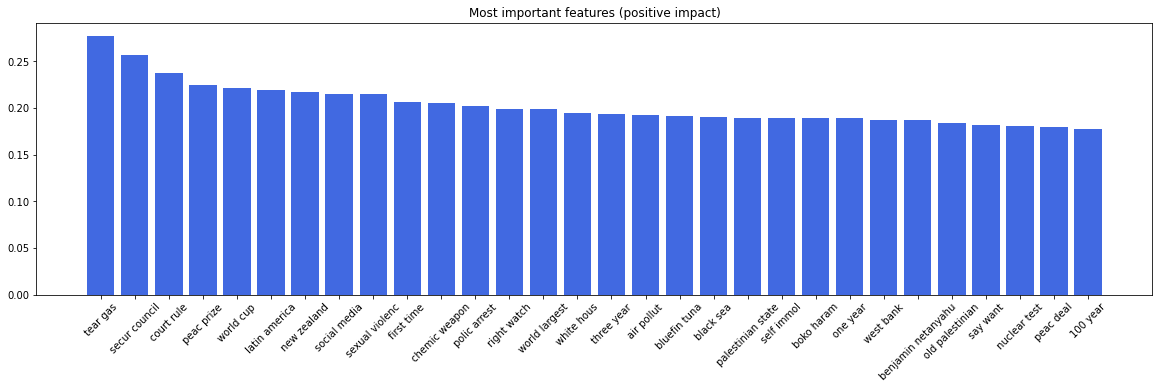

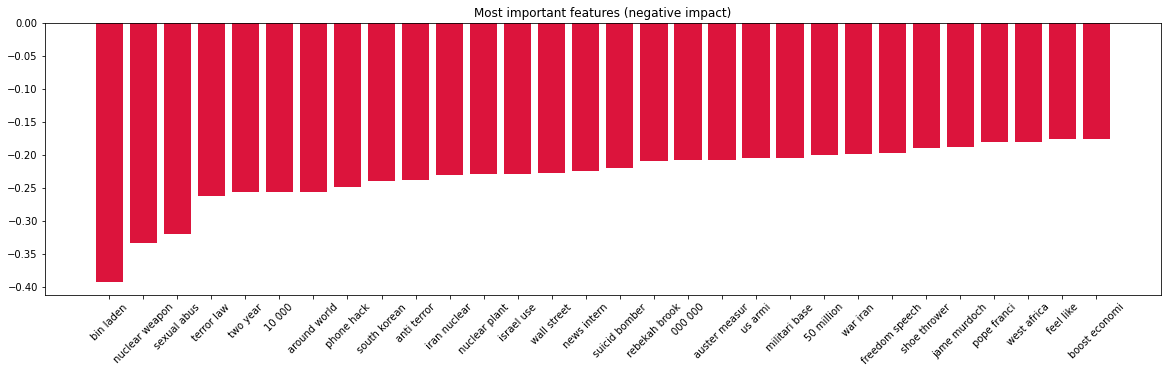

In [ ]:
tfidf_importances = list(zip(vectorizer.get_feature_names(), cbr.coef_[0]))
tfidf_importances_sorted = sorted(tfidf_importances, key=lambda x: x[1], reverse=True)
tfidf_importances_desorted = sorted(tfidf_importances, key=lambda x: x[1])

plt.figure(figsize=(20, 5))
plt.bar([x[0] for x in tfidf_importances_sorted[:30]], [x[1] for x in tfidf_importances_sorted[:30]], color='royalblue')
plt.title('Most important features (positive impact)')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(20, 5))
plt.bar([x[0] for x in tfidf_importances_desorted[:30]], [x[1] for x in tfidf_importances_desorted[:30]], color='crimson')
plt.title('Most important features (negative impact)')
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


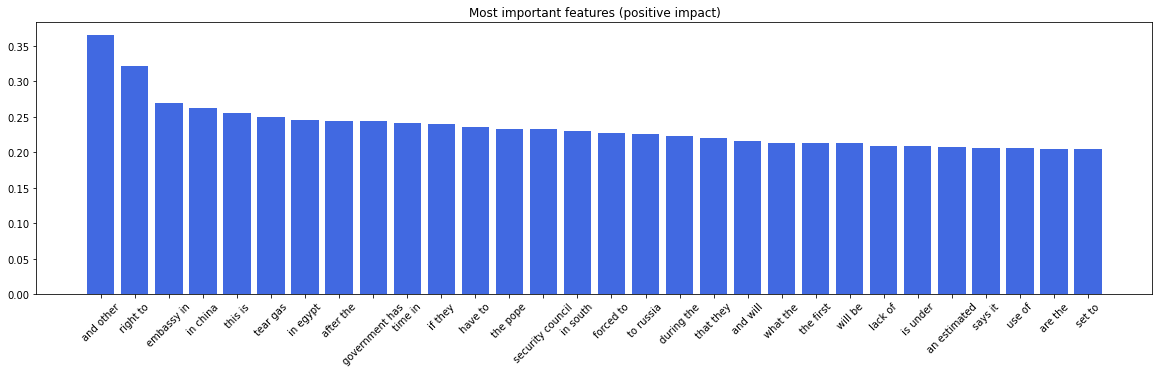

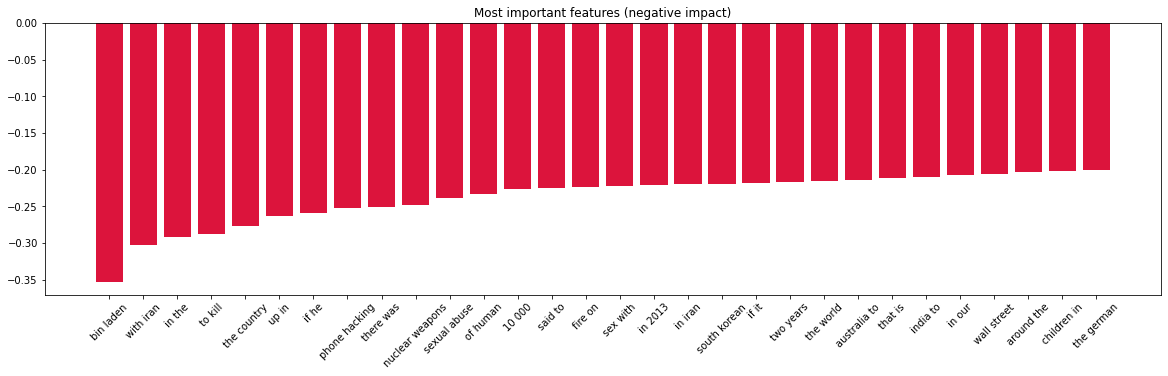

In [ ]:
tfidf_importances = list(zip(vectorizer.get_feature_names(), cbr.coef_[0]))
tfidf_importances_sorted = sorted(tfidf_importances, key=lambda x: x[1], reverse=True)
tfidf_importances_desorted = sorted(tfidf_importances, key=lambda x: x[1])

plt.figure(figsize=(20, 5))
plt.bar([x[0] for x in tfidf_importances_sorted[:30]], [x[1] for x in tfidf_importances_sorted[:30]], color='royalblue')
plt.title('Most important features (positive impact)')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(20, 5))
plt.bar([x[0] for x in tfidf_importances_desorted[:30]], [x[1] for x in tfidf_importances_desorted[:30]], color='crimson')
plt.title('Most important features (negative impact)')
plt.xticks(rotation=45)
plt.show()

### vectorization

In [ ]:
# tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(2,2)) #max_features=100000, min_df=1
headlines_tfidf = tfidf.fit_transform(df.headlines_stem)
print(len(tfidf.vocabulary_), headlines_tfidf.shape)

393050 (1989, 393050)


In [ ]:
# spacy
import spacy

spacy_nlp = spacy.load("en_core_web_sm")

def spacy_encoder(txt):
  return spacy_nlp(txt).vector

headlines_tfidf = df.headlines_stem.apply(spacy_encoder)
print(headlines_tfidf.shape)

# reshape 
headlines_tfidf = np.array(
    headlines_tfidf.tolist()).reshape((len(headlines_tfidf), len(headlines_tfidf[0])))

### model

In [ ]:
# ! pip install catboost

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression

val_thr = len(df) - (len(df) // 4)
X_train, X_val, y_train, y_val = headlines_tfidf[:val_thr], headlines_tfidf[val_thr:], df.target[:val_thr], df.target[val_thr:]
# X_train, X_val, y_train, y_val = headlines_tfidf[:val_thr], headlines_tfidf[val_thr:], df.Label[:val_thr], df.Label[val_thr:]
# X_train, X_val, y_train, y_val = train_test_split(headlines_tfidf, df.target, test_size=0.3)

cbr = CatBoostClassifier(iterations=100,max_depth=4) # ,learning_rate=1
cbr.fit(X_train, y_train, silent=True)
# cbr = LogisticRegression()
# cbr.fit(X_train, y_train)

In [ ]:
# eval
cbr_pred = cbr.predict(X_train)
cbr_pred_proba = cbr.predict_proba(X_train)
print('accuracy: {}'.format(accuracy_score(y_train, cbr_pred)))
print('precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_train, cbr_pred, average='binary')))
print('roc_auc_score: {}'.format(roc_auc_score(y_train, cbr_pred_proba[:, 1])))

accuracy: 0.7888739946380697
precision_recall_fscore_support: (0.7280296022201665, 0.974009900990099, 0.8332451032292219, None)
roc_auc_score: 0.9255878712871287


In [ ]:
# eval
cbr_pred = cbr.predict(X_val)
cbr_pred_proba = cbr.predict_proba(X_val)
print('accuracy: {}'.format(accuracy_score(y_val, cbr_pred)))
print('precision_recall_fscore_support: {}'.format(precision_recall_fscore_support(y_val, cbr_pred, average='binary')))
print('roc_auc_score: {}'.format(roc_auc_score(y_val, cbr_pred_proba[:, 1])))

accuracy: 0.5211267605633803
precision_recall_fscore_support: (0.5219399538106235, 0.8793774319066148, 0.6550724637681159, None)
roc_auc_score: 0.527261673151751


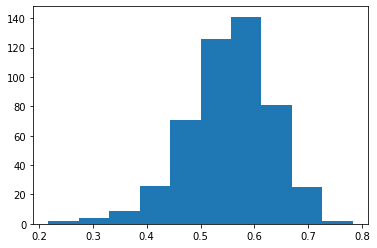

In [ ]:
plt.hist(cbr_pred_proba[:, 1])
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


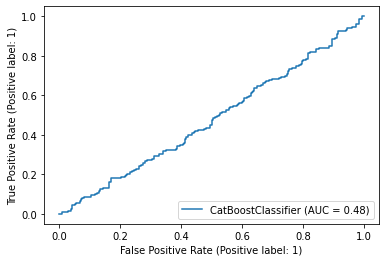

In [ ]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(cbr, X_val, y_val)
plt.show()

# BBC parser

In [ ]:
# https://towardsdatascience.com/super-simple-way-to-scrape-bbc-news-articles-in-python-5fe1e6ee82d9
def get_bbc_title(url:str) -> str:
    """Parse bbc article and return the Title"""
    
    article = requests.get(url)
    soup = bs(article.content, "html.parser")
    # title = soup.find(class_='story-body__h1').text
    title = soup.find(class_='ssrcss-15xko80-StyledHeading e1fj1fc10').text
    dattetime = soup.find(class_='ssrcss-8g95ls-MetadataSnippet ecn1o5v2').text
    return dattetime, title

In [ ]:
get_bbc_title('https://www.bbc.com/news/business-60979656')
get_bbc_title('https://www.bbc.com/news/business-60938730')

('4 days ago', 'Energy websites crash in meter readings rush')

In [ ]:
dattetime.text

'4 days ago'

# Australian news

In [ ]:
# https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/SYBGZL
df = pd.read_csv('abcnews-date-text.csv')
print(df.shape)
df.head()

(1226258, 2)


,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [ ]:
df.publish_date.min(), df.publish_date.max()

(20030219, 20201231)

In [ ]:
df['publish_year'] = df.publish_date.apply(lambda x: str(x)[:4])
df['publish_year_month'] = df.publish_date.apply(lambda x: str(x)[:6])
df['publish_month'] = df.publish_date.apply(lambda x: str(x)[4:6])
df['publish_quarter'] = df.publish_date.apply(lambda x: 'Q' + str((int(str(x)[4:6])-1) // 3 + 1))
df['publish_year_quarter'] = df.publish_date.apply(lambda x: str(x)[:4] + '-Q' + str((int(str(x)[4:6])-1) // 3 + 1))

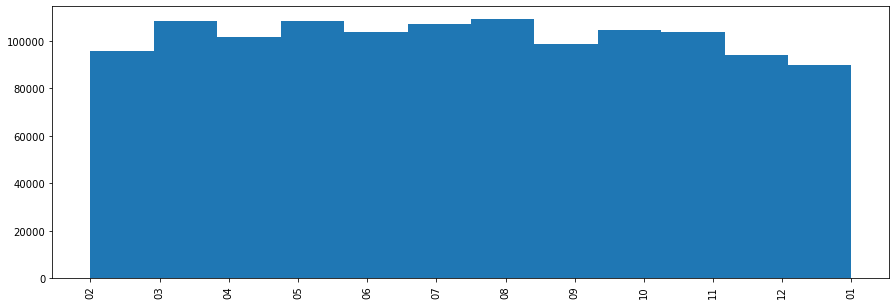

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(df.publish_month, bins=12)
plt.xticks(rotation=90)
plt.show()

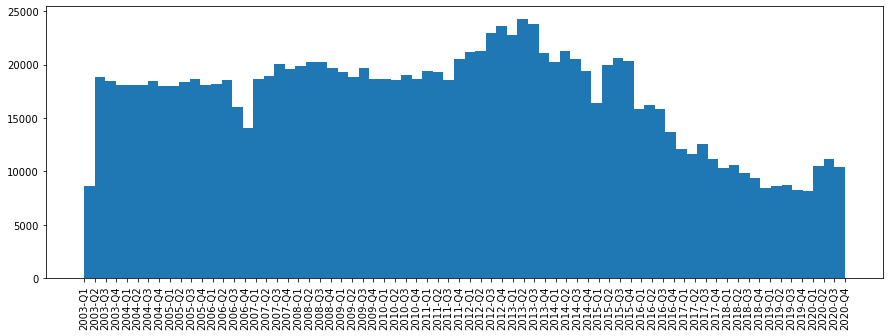

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(df.publish_year_quarter, bins=18*4)
plt.xticks(rotation=90)
plt.show()

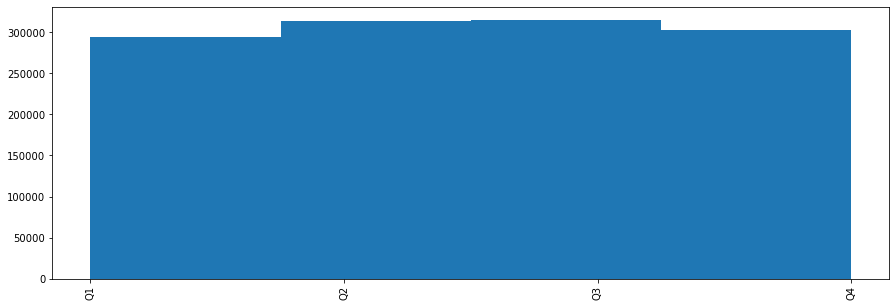

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(df.publish_quarter, bins=4)
plt.xticks(rotation=90)
plt.show()

### preprocessing

In [ ]:
# ! python -m spacy download en_core_web_sm

In [ ]:
from nltk.tokenize import word_tokenize
from pymystem3 import Mystem
from string import punctuation
from nltk.stem.snowball import SnowballStemmer
import spacy

stemmer = SnowballStemmer('english')
spacy_nlp = spacy.load('en_core_web_sm')
mystem = Mystem()

def custom_stemmer(sent):
    return ' '.join([stemmer.stem(w.lower()) for w in word_tokenize(sent) 
                     if w not in spacy_nlp.Defaults.stop_words
                    and w not in punctuation])

# takes time
df['headline_stem'] = df['headline_text'].apply(custom_stemmer)

In [ ]:
print(df.headline_text[0])
print(custom_stemmer(df.headline_text[0]))

aba decides against community broadcasting licence
aba decid communiti broadcast licenc


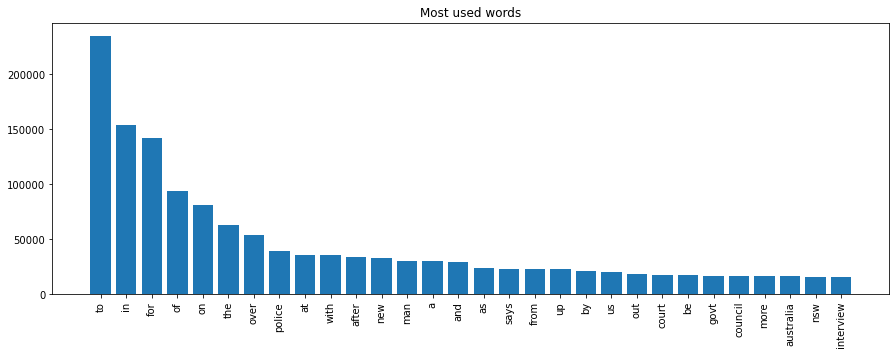

In [ ]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer

tok = Tokenizer(num_words=100000, oov_token='<UNK>')
tok.fit_on_texts(df.headline_text)

top_used_words = sorted(dict(tok.word_counts).items(), key=lambda x: x[1], reverse=True)[:30]

plt.figure(figsize=(15, 5))
plt.bar(list(zip(*top_used_words))[0], list(zip(*top_used_words))[1])
plt.title('Most used words')
plt.xticks(rotation=90)
plt.show()

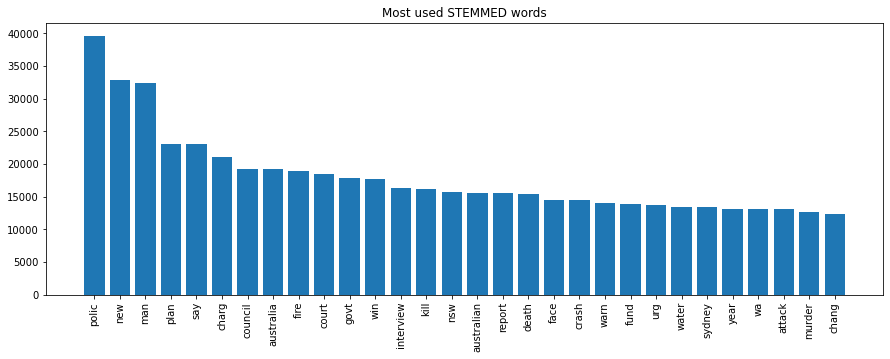

In [ ]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer

tok = Tokenizer(num_words=100000, oov_token='<UNK>')
tok.fit_on_texts(df.headline_stem)

top_used_words = sorted(dict(tok.word_counts).items(), key=lambda x: x[1], reverse=True)[:30]

plt.figure(figsize=(15, 5))
plt.bar(list(zip(*top_used_words))[0], list(zip(*top_used_words))[1])
plt.title('Most used STEMMED words')
plt.xticks(rotation=90)
plt.show()

### Vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=5)
headlines_tfidf = tfidf.fit_transform(df.headline_stem)

In [ ]:
print(len(tfidf.vocabulary_), headlines_tfidf.shape)

28162 (1226258, 28162)


### model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support